In [68]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
torch.manual_seed(1)

In [69]:
#Hyperparameter
learning_rate = 2e-4
batch_size = 1024
auxiliary_loss_ratio = 1
weight_decay = 1e-3
epochs = 400
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drop_out_rate = 0.3

In [70]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(nn.Linear(16, 32),
                                       nn.LeakyReLU(),
                                       nn.Dropout(drop_out_rate),
                                       nn.Linear(32, 64),
                                       nn.LeakyReLU(),
                                       nn.Dropout(drop_out_rate),
                                       nn.Linear(64, 128),
                                       nn.LeakyReLU(),
                                       nn.Dropout(drop_out_rate),
                                       nn.Linear(128, 256),
                                       nn.LeakyReLU(),
                                       nn.Dropout(drop_out_rate),
                                       nn.Linear(256, 512),
                                       nn.LeakyReLU(),
                                       nn.Dropout(drop_out_rate),
                                       nn.Linear(512, 784),
                                       nn.Tanh())

    def forward(self, tensor):
        tensor = self.generator(tensor)
        tensor = tensor.view(-1, 1, 28, 28)
        return tensor

In [71]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(nn.Linear(784, 512),
                                           nn.LeakyReLU(),
                                           nn.Dropout(drop_out_rate),
                                           nn.Linear(512, 256),
                                           nn.LeakyReLU(),
                                           nn.Dropout(drop_out_rate),
                                           nn.Linear(256, 128),
                                           nn.LeakyReLU(),
                                           nn.Dropout(drop_out_rate),
                                           nn.Linear(128, 64),
                                           nn.LeakyReLU(),
                                           nn.Dropout(drop_out_rate),
                                           nn.Linear(64, 32),
                                           nn.LeakyReLU(),
                                           nn.Dropout(drop_out_rate),
                                           nn.Linear(32, 16),
                                           nn.LeakyReLU(),
                                           nn.Dropout(drop_out_rate),
                                           nn.Linear(16, 11))

    def discriminate(self, tensor):
        tensor = tensor.view(-1, 784)
        tensor = self.discriminator(tensor)
        return tensor

    def forward(self, tensor):
        tensor = self.discriminate(tensor)
        return tensor

In [72]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [73]:
class ExponentialLRWithMin:
    def __init__(self, optimizer, gamma, min_lr):
        self.optimizer = optimizer
        self.gamma = gamma
        self.min_lr = min_lr

    def step(self):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = max(param_group['lr'] * self.gamma, self.min_lr)

In [74]:
criterion_generator = nn.MSELoss()
criterion_discriminator = nn.CrossEntropyLoss()

optimizer_generator = opt.Adam(generator.parameters(), lr = learning_rate, weight_decay = weight_decay)
optimizer_discriminator = opt.Adam(discriminator.parameters(), lr = learning_rate, weight_decay = weight_decay)
# scheduler_generator = ExponentialLRWithMin(optimizer_generator, gamma=0.7, min_lr=2e-5)
# scheduler_discriminator = ExponentialLRWithMin(optimizer_discriminator, gamma=0.7, min_lr=2e-5)

In [75]:
# Prepare the dataset and dataloader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create the dataset
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)

In [76]:
def input_creator(labels):
    list_of_input = []
    for i in range(labels.numel()):
        noise = torch.randn(6)
        label = torch.zeros(10)
        label[labels[i]] = 1

        input = torch.concatenate((noise, label), 0)
        list_of_input.append(input)

    list_of_input = torch.stack(list_of_input)
    list_of_input = list_of_input.view(-1, 16)
    list_of_input = list_of_input.to(device)
    return list_of_input

In [77]:
def find_label(labels):
    list_of_input = []
    for i in range(labels.numel()):
        label = torch.zeros(11)
        label[labels[i]] = 1

        list_of_input.append(label)

    list_of_input = torch.stack(list_of_input)
    list_of_input = list_of_input.to(device)
    return list_of_input

In [78]:
def create_fake_label(output):
    label = torch.zeros_like(output).to(device)
    label[:,10] = 1
    return label

In [79]:
#To keep a balance between generator and discriminator
#I have these two variables. They determin how many times each part is trained.
#For example, if discriminator is overpowering generator, I will train generator
#twice for every one training for discriminator
num_train_discriminator = 2
num_train_generator = 2

Discriminator real loss 2.0038976669311523
Discriminator fake loss 2.382103681564331
Discriminator real loss 1.9580565690994263
Discriminator fake loss 2.383831739425659
Generator loss 2.394787311553955
Generator auxiliary loss 0.2789062559604645
Generator loss 2.374049186706543
Generator auxiliary loss 0.2784845530986786
2.285031795501709


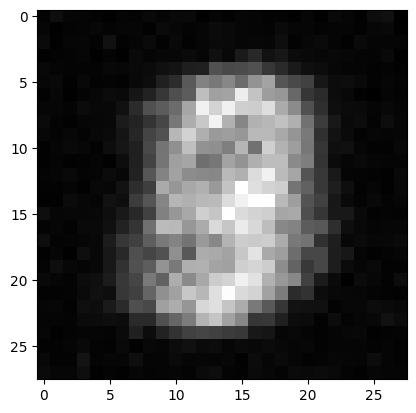

Discriminator real loss 1.5554076433181763
Discriminator fake loss 2.319817304611206
Discriminator real loss 1.5076782703399658
Discriminator fake loss 2.314255952835083
Discriminator real loss 1.5094341039657593
Discriminator fake loss 2.3097314834594727
Generator loss 2.2990474700927734
Generator auxiliary loss 0.28020548820495605
Generator loss 2.2516305446624756
Generator auxiliary loss 0.2799775004386902
2.271696090698242


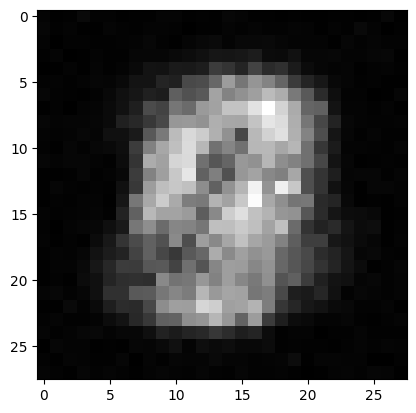

Discriminator real loss 1.3802419900894165
Discriminator fake loss 1.8263858556747437
Discriminator real loss 1.4097779989242554
Discriminator fake loss 1.8254714012145996
Discriminator real loss 1.347947120666504
Discriminator fake loss 1.8327909708023071
Generator loss 1.8295189142227173
Generator auxiliary loss 0.27403050661087036
Generator loss 1.8224172592163086
Generator auxiliary loss 0.27307844161987305
1.9099690914154053


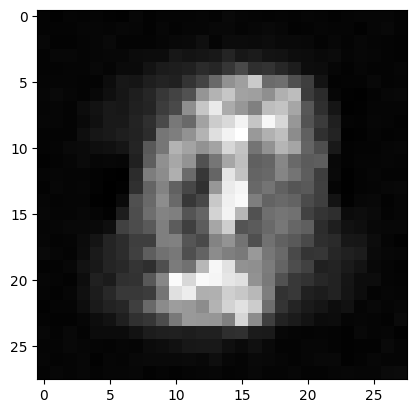

Discriminator real loss 0.9769171476364136
Discriminator fake loss 1.3554264307022095
Discriminator real loss 0.9982442259788513
Discriminator fake loss 1.33161199092865
Discriminator real loss 1.0286768674850464
Discriminator fake loss 1.3327267169952393
Generator loss 1.3589506149291992
Generator auxiliary loss 0.2691798210144043
Generator loss 1.2961139678955078
Generator auxiliary loss 0.2686299979686737
1.357419729232788


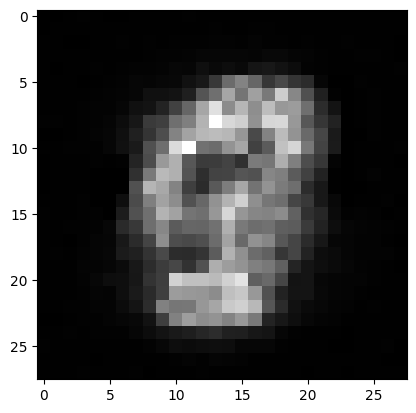

Discriminator real loss 0.9415345191955566
Discriminator fake loss 1.0688519477844238
Discriminator real loss 0.9533119201660156
Discriminator fake loss 1.0508811473846436
Discriminator real loss 0.9386273622512817
Discriminator fake loss 1.0192376375198364
Generator loss 1.0404471158981323
Generator auxiliary loss 0.2683013379573822
Generator loss 1.079903244972229
Generator auxiliary loss 0.2692166864871979
0.9949647784233093


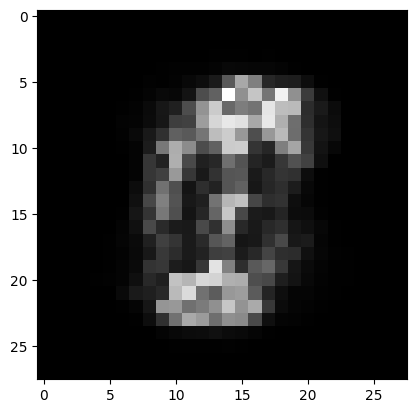

Discriminator real loss 0.8007424473762512
Discriminator fake loss 0.8616610169410706
Discriminator real loss 0.8351783752441406
Discriminator fake loss 0.8543664216995239
Discriminator real loss 0.7505338788032532
Discriminator fake loss 0.8570480346679688
Generator loss 0.8437921404838562
Generator auxiliary loss 0.2722489535808563
Generator loss 0.9271687865257263
Generator auxiliary loss 0.27202242612838745
0.7571481466293335


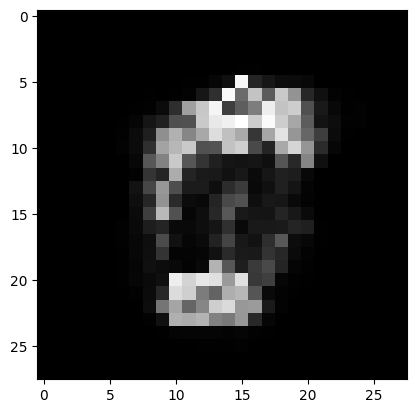

Discriminator real loss 0.66552734375
Discriminator fake loss 0.7272094488143921
Discriminator real loss 0.7564303874969482
Discriminator fake loss 0.6821994781494141
Discriminator real loss 0.710426926612854
Discriminator fake loss 0.7174572944641113
Generator loss 0.7223598957061768
Generator auxiliary loss 0.26890745759010315
Generator loss 0.6486830711364746
Generator auxiliary loss 0.2692115008831024
0.4693470597267151


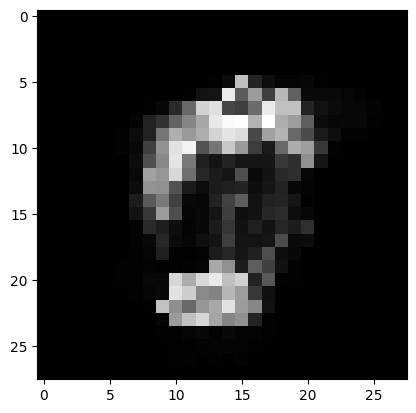

Discriminator real loss 0.7044103145599365
Discriminator fake loss 0.6745492219924927
Discriminator real loss 0.6088739037513733
Discriminator fake loss 0.6543498635292053
Discriminator real loss 0.6709395051002502
Discriminator fake loss 0.6043313145637512
Generator loss 0.5951530337333679
Generator auxiliary loss 0.2668597400188446
Generator loss 0.6386399269104004
Generator auxiliary loss 0.2671455442905426
0.4350109100341797


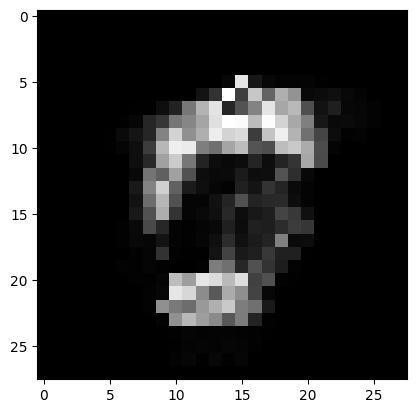

Discriminator real loss 0.7259936332702637
Discriminator fake loss 0.5968776345252991
Discriminator real loss 0.7129571437835693
Discriminator fake loss 0.5900823473930359
Discriminator real loss 0.6936599612236023
Discriminator fake loss 0.5879938006401062
Generator loss 0.5436754822731018
Generator auxiliary loss 0.2731574475765228
Generator loss 0.5747296810150146
Generator auxiliary loss 0.2747109532356262
0.5416536331176758


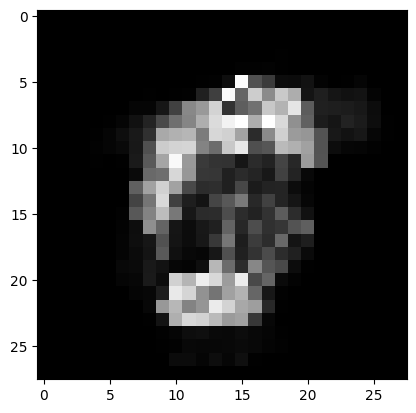

Discriminator real loss 0.5975534319877625
Discriminator fake loss 0.4834303557872772
Discriminator real loss 0.6017729043960571
Discriminator fake loss 0.45676302909851074
Discriminator real loss 0.5602988600730896
Discriminator fake loss 0.48788702487945557
Generator loss 0.48174306750297546
Generator auxiliary loss 0.275690495967865
Generator loss 0.45977330207824707
Generator auxiliary loss 0.27435100078582764
0.6458341479301453


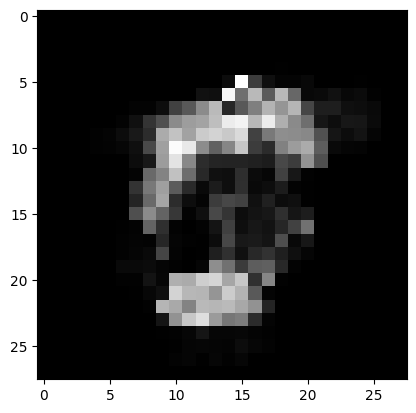

Discriminator real loss 0.4548519551753998
Discriminator fake loss 0.4040345549583435
Discriminator real loss 0.3897583782672882
Discriminator fake loss 0.4559767246246338
Discriminator real loss 0.4579885005950928
Discriminator fake loss 0.467491090297699
Generator loss 0.4813825190067291
Generator auxiliary loss 0.2722781300544739
Generator loss 0.4524284601211548
Generator auxiliary loss 0.272531658411026
0.494215190410614


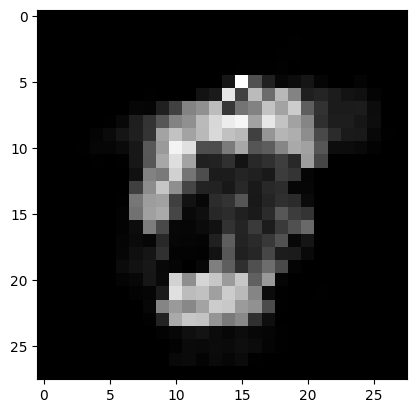

Discriminator real loss 0.5548306703567505
Discriminator fake loss 0.3678670823574066
Discriminator real loss 0.5435131788253784
Discriminator fake loss 0.3663173317909241
Discriminator real loss 0.5937835574150085
Discriminator fake loss 0.37329256534576416
Generator loss 0.3942407965660095
Generator auxiliary loss 0.27612441778182983
Generator loss 0.3810440003871918
Generator auxiliary loss 0.2766357958316803
0.4502374231815338


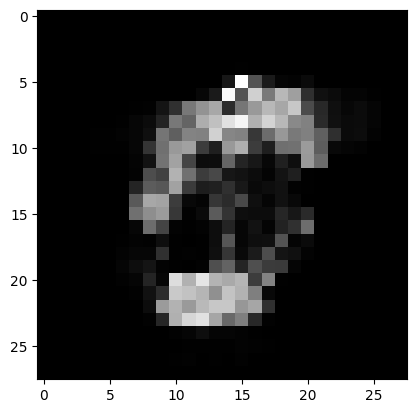

Discriminator real loss 0.49246907234191895
Discriminator fake loss 0.3103318512439728
Discriminator real loss 0.47029900550842285
Discriminator fake loss 0.31410983204841614
Discriminator real loss 0.5045775771141052
Discriminator fake loss 0.3208620548248291
Generator loss 0.3311135172843933
Generator auxiliary loss 0.2744470238685608
Generator loss 0.28394201397895813
Generator auxiliary loss 0.2747931182384491
0.4036800265312195


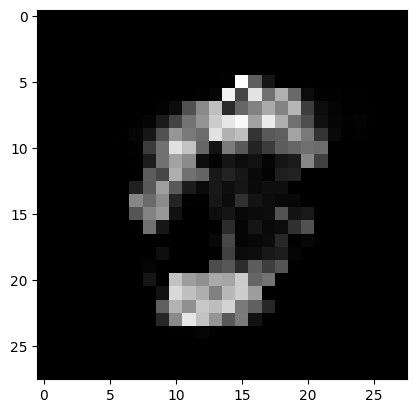

Discriminator real loss 0.4888404607772827
Discriminator fake loss 0.3151451647281647
Discriminator real loss 0.4339790940284729
Discriminator fake loss 0.2896006107330322
Discriminator real loss 0.483614057302475
Discriminator fake loss 0.2539672553539276
Generator loss 0.2654777467250824
Generator auxiliary loss 0.27297303080558777
Generator loss 0.27488604187965393
Generator auxiliary loss 0.27369406819343567
0.6122629046440125


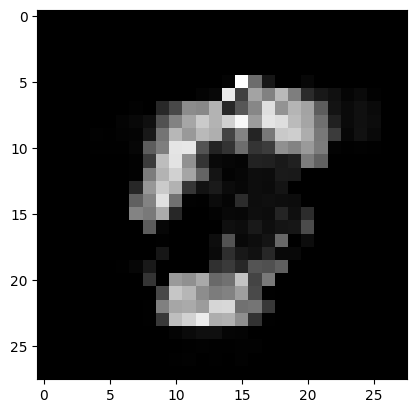

Discriminator real loss 0.44691166281700134
Discriminator fake loss 0.24668040871620178
Discriminator real loss 0.4420548975467682
Discriminator fake loss 0.26819559931755066
Discriminator real loss 0.374103307723999
Discriminator fake loss 0.2586786448955536
Generator loss 0.3478768765926361
Generator auxiliary loss 0.27029794454574585
Generator loss 0.33008071780204773
Generator auxiliary loss 0.2702520191669464
0.08387720584869385


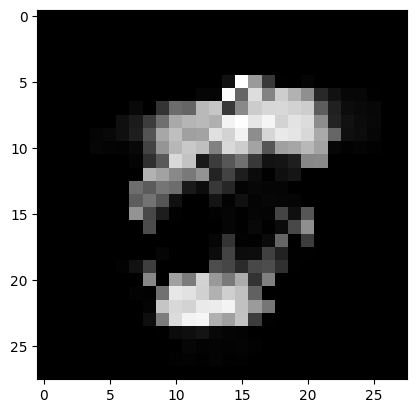

Discriminator real loss 0.36119481921195984
Discriminator fake loss 0.2266046106815338
Discriminator real loss 0.3447337746620178
Discriminator fake loss 0.2437460571527481
Generator loss 0.24323907494544983
Generator auxiliary loss 0.26957711577415466
Generator loss 0.3070203959941864
Generator auxiliary loss 0.27036717534065247
Generator loss 0.22484950721263885
Generator auxiliary loss 0.2691403925418854
0.4355691075325012


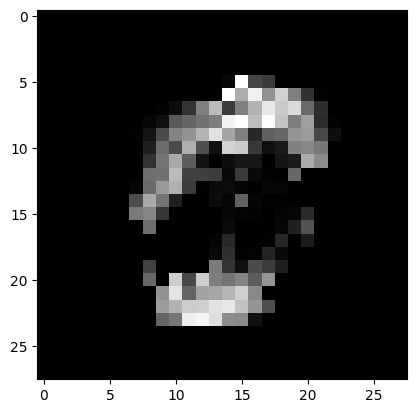

Discriminator real loss 0.4260750412940979
Discriminator fake loss 0.20020799338817596
Discriminator real loss 0.4475197494029999
Discriminator fake loss 0.1554015427827835
Discriminator real loss 0.4153759479522705
Discriminator fake loss 0.18843574821949005
Generator loss 0.1991606205701828
Generator auxiliary loss 0.2678599953651428
Generator loss 0.2143830806016922
Generator auxiliary loss 0.2665887773036957
0.10398473590612411


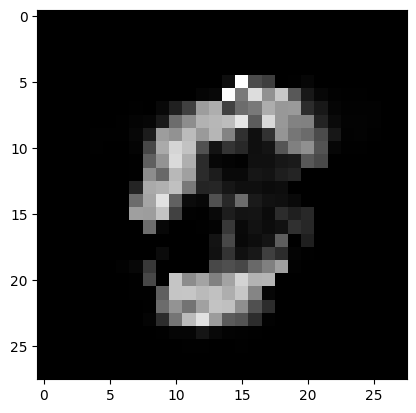

Discriminator real loss 0.33193281292915344
Discriminator fake loss 0.20026035606861115
Discriminator real loss 0.36251479387283325
Discriminator fake loss 0.22606956958770752
Generator loss 0.21478956937789917
Generator auxiliary loss 0.26164886355400085
Generator loss 0.2814662456512451
Generator auxiliary loss 0.2615329325199127
0.08230184018611908


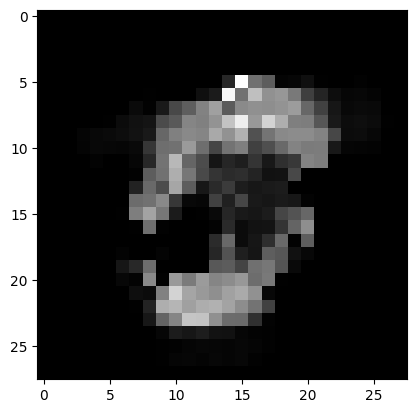

Discriminator real loss 0.34151318669319153
Discriminator fake loss 0.24023126065731049
Discriminator real loss 0.33756864070892334
Discriminator fake loss 0.17170190811157227
Generator loss 0.17677029967308044
Generator auxiliary loss 0.2708573341369629
Generator loss 0.185807466506958
Generator auxiliary loss 0.2673301100730896
Generator loss 0.21142931282520294
Generator auxiliary loss 0.26785600185394287
0.06770999729633331


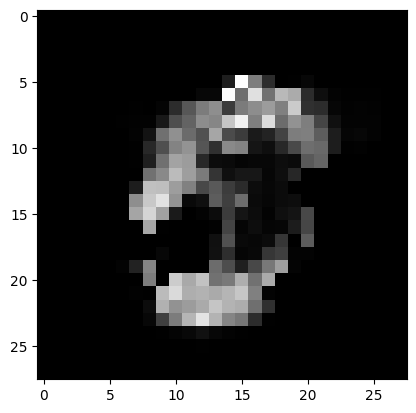

Discriminator real loss 0.29280003905296326
Discriminator fake loss 0.16339123249053955
Discriminator real loss 0.2783042788505554
Discriminator fake loss 0.17951348423957825
Generator loss 0.16044729948043823
Generator auxiliary loss 0.26744985580444336
Generator loss 0.19425120949745178
Generator auxiliary loss 0.26730233430862427
Generator loss 0.21588975191116333
Generator auxiliary loss 0.26687830686569214
0.09150250256061554


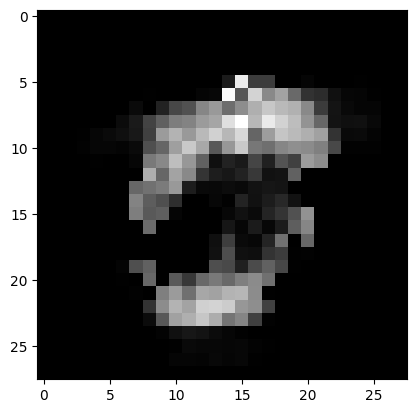

Discriminator real loss 0.3170437812805176
Discriminator fake loss 0.1805008053779602
Discriminator real loss 0.3090205788612366
Discriminator fake loss 0.16668300330638885
Generator loss 0.1609535813331604
Generator auxiliary loss 0.27139514684677124
Generator loss 0.1979682296514511
Generator auxiliary loss 0.271209180355072
Generator loss 0.2550683915615082
Generator auxiliary loss 0.2720859944820404
0.09855066239833832


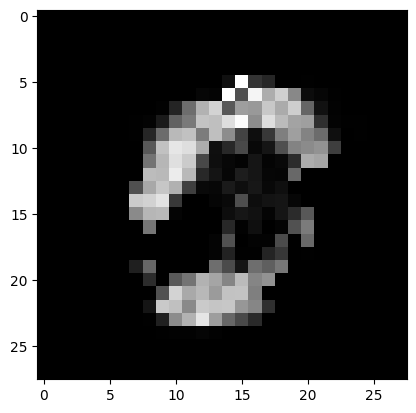

Discriminator real loss 0.302371084690094
Discriminator fake loss 0.18715646862983704
Discriminator real loss 0.3144480884075165
Discriminator fake loss 0.18711650371551514
Generator loss 0.22063395380973816
Generator auxiliary loss 0.26234114170074463
Generator loss 0.15481054782867432
Generator auxiliary loss 0.26231813430786133
Generator loss 0.17457114160060883
Generator auxiliary loss 0.2620396912097931
0.05434119701385498


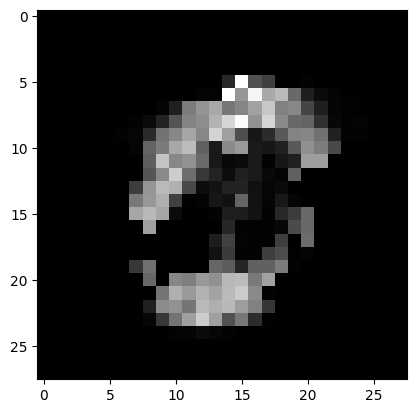

Discriminator real loss 0.290695458650589
Discriminator fake loss 0.16382955014705658
Discriminator real loss 0.25449585914611816
Discriminator fake loss 0.17847084999084473
Generator loss 0.13954724371433258
Generator auxiliary loss 0.2586973309516907
Generator loss 0.1787378042936325
Generator auxiliary loss 0.25816240906715393
Generator loss 0.12944090366363525
Generator auxiliary loss 0.25825077295303345
0.3837883174419403


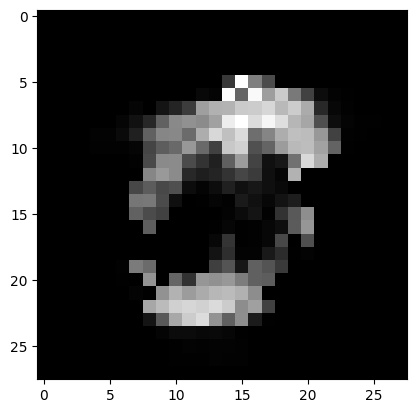

Discriminator real loss 0.3989291191101074
Discriminator fake loss 0.1555912047624588
Discriminator real loss 0.36860474944114685
Discriminator fake loss 0.15843959152698517
Generator loss 0.14763079583644867
Generator auxiliary loss 0.265032559633255
Generator loss 0.13754905760288239
Generator auxiliary loss 0.26446768641471863
0.08352206647396088


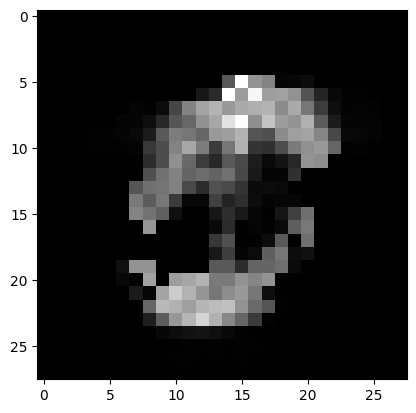

Discriminator real loss 0.2910606861114502
Discriminator fake loss 0.14990085363388062
Discriminator real loss 0.40691712498664856
Discriminator fake loss 0.13949406147003174
Generator loss 0.1430196613073349
Generator auxiliary loss 0.2622258961200714
Generator loss 0.1461673229932785
Generator auxiliary loss 0.2623070180416107
Generator loss 0.16620251536369324
Generator auxiliary loss 0.2627851366996765
0.19620200991630554


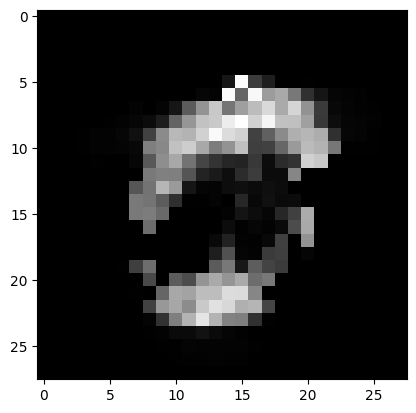

Discriminator real loss 0.33157187700271606
Discriminator fake loss 0.15297643840312958
Discriminator real loss 0.3331015408039093
Discriminator fake loss 0.13114377856254578
Generator loss 0.14407068490982056
Generator auxiliary loss 0.26415249705314636
Generator loss 0.1292213350534439
Generator auxiliary loss 0.265264630317688
0.01770898886024952


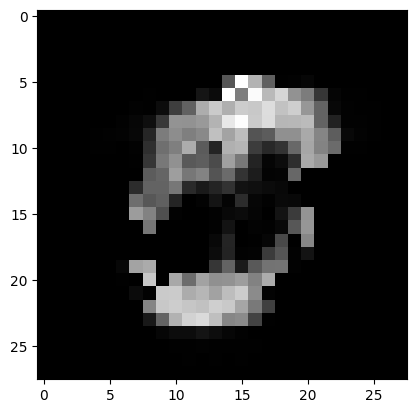

Discriminator real loss 0.3388898968696594
Discriminator fake loss 0.13323067128658295
Discriminator real loss 0.3089796006679535
Discriminator fake loss 0.13815438747406006
Generator loss 0.15764272212982178
Generator auxiliary loss 0.25813302397727966
Generator loss 0.1398250311613083
Generator auxiliary loss 0.2584921717643738
Generator loss 0.11861804872751236
Generator auxiliary loss 0.2589918375015259
0.061227280646562576


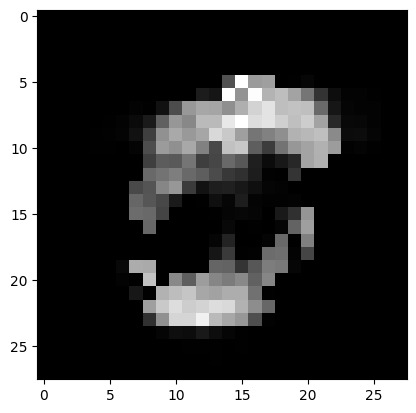

Discriminator real loss 0.2749379873275757
Discriminator fake loss 0.1458241492509842
Discriminator real loss 0.3064325153827667
Discriminator fake loss 0.20427502691745758
Generator loss 0.12863846123218536
Generator auxiliary loss 0.26280757784843445
Generator loss 0.14439783990383148
Generator auxiliary loss 0.2630033493041992
Generator loss 0.1543465405702591
Generator auxiliary loss 0.2621009945869446
0.12269828468561172


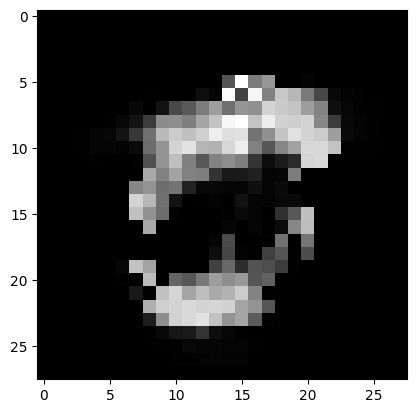

Discriminator real loss 0.26469480991363525
Discriminator fake loss 0.1268254518508911
Discriminator real loss 0.24578344821929932
Discriminator fake loss 0.13113753497600555
Generator loss 0.12979300320148468
Generator auxiliary loss 0.26179033517837524
Generator loss 0.14636589586734772
Generator auxiliary loss 0.26005667448043823
0.24693432450294495


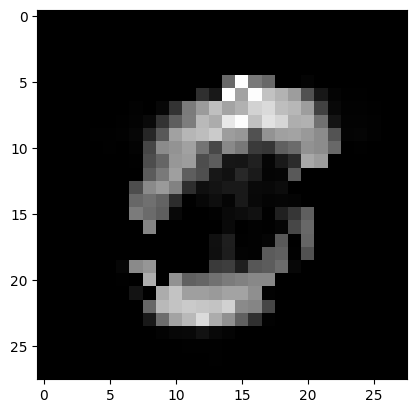

Discriminator real loss 0.2783602774143219
Discriminator fake loss 0.1107284426689148
Discriminator real loss 0.2907559871673584
Discriminator fake loss 0.14398817718029022
Generator loss 0.12124992907047272
Generator auxiliary loss 0.250100702047348
Generator loss 0.15592221915721893
Generator auxiliary loss 0.251329243183136
0.032960087060928345


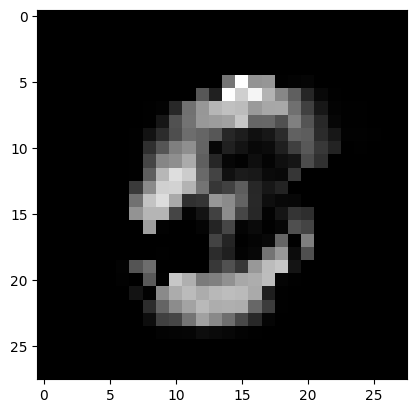

Discriminator real loss 0.24264779686927795
Discriminator fake loss 0.11962153017520905
Discriminator real loss 0.288250207901001
Discriminator fake loss 0.14532652497291565
Generator loss 0.14375172555446625
Generator auxiliary loss 0.25933805108070374
Generator loss 0.12419456988573074
Generator auxiliary loss 0.2591950595378876
Generator loss 0.16001512110233307
Generator auxiliary loss 0.25922781229019165
0.07703335583209991


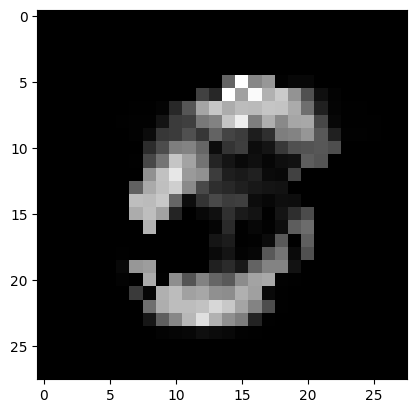

Discriminator real loss 0.22186648845672607
Discriminator fake loss 0.1220191940665245
Discriminator real loss 0.33472180366516113
Discriminator fake loss 0.13184776902198792
Generator loss 0.15225422382354736
Generator auxiliary loss 0.2638518512248993
Generator loss 0.11205986887216568
Generator auxiliary loss 0.263048380613327
Generator loss 0.14848832786083221
Generator auxiliary loss 0.26263755559921265
0.13487747311592102


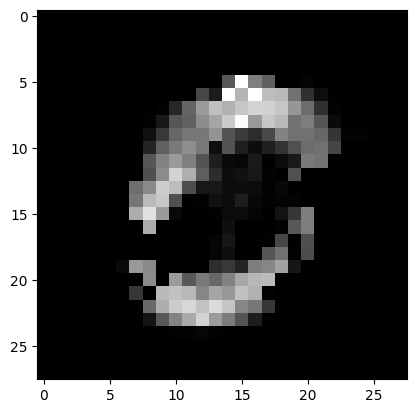

Discriminator real loss 0.2344997078180313
Discriminator fake loss 0.13354143500328064
Discriminator real loss 0.2285064458847046
Discriminator fake loss 0.12764567136764526
Generator loss 0.0914689153432846
Generator auxiliary loss 0.25665152072906494
Generator loss 0.1601739525794983
Generator auxiliary loss 0.25812679529190063
0.19620534777641296


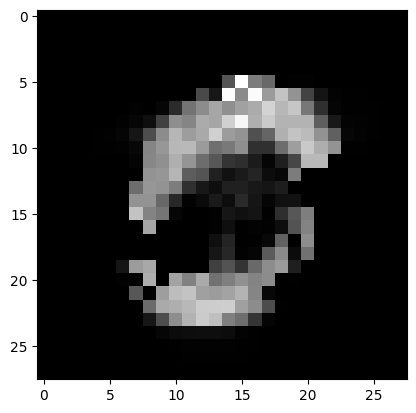

Discriminator real loss 0.31358659267425537
Discriminator fake loss 0.12070832401514053
Discriminator real loss 0.26044440269470215
Discriminator fake loss 0.10449040681123734
Generator loss 0.10704242438077927
Generator auxiliary loss 0.2581315338611603
Generator loss 0.15966181457042694
Generator auxiliary loss 0.25842157006263733
0.13175241649150848


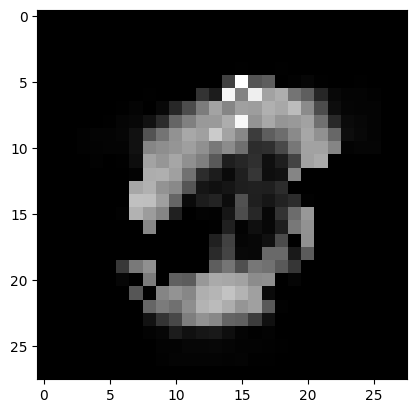

Discriminator real loss 0.22763046622276306
Discriminator fake loss 0.1269233226776123
Discriminator real loss 0.23492735624313354
Discriminator fake loss 0.11068659275770187
Generator loss 0.1268365979194641
Generator auxiliary loss 0.26393401622772217
Generator loss 0.11501263082027435
Generator auxiliary loss 0.26337456703186035
0.04098320007324219


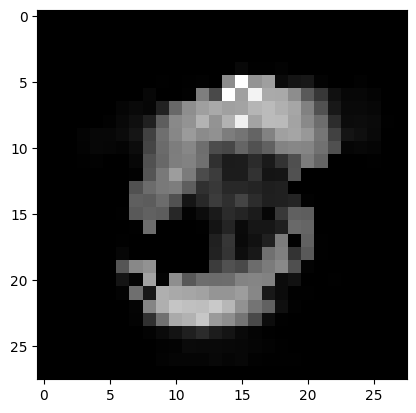

Discriminator real loss 0.23836004734039307
Discriminator fake loss 0.11623786389827728
Discriminator real loss 0.24883227050304413
Discriminator fake loss 0.09507014602422714
Generator loss 0.12773360311985016
Generator auxiliary loss 0.25741904973983765
Generator loss 0.1291699856519699
Generator auxiliary loss 0.25704625248908997
Generator loss 0.12011949717998505
Generator auxiliary loss 0.2563125789165497
0.03544826805591583


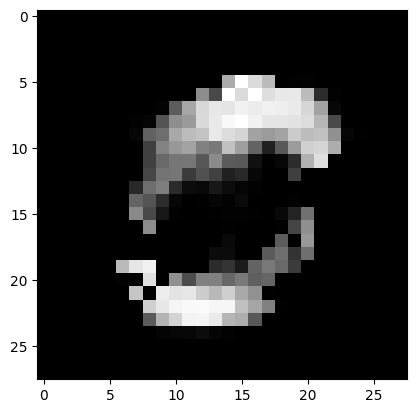

Discriminator real loss 0.26207205653190613
Discriminator fake loss 0.11243852972984314
Discriminator real loss 0.25643864274024963
Discriminator fake loss 0.15343408286571503
Generator loss 0.15115270018577576
Generator auxiliary loss 0.25793078541755676
Generator loss 0.133212611079216
Generator auxiliary loss 0.25837811827659607
Generator loss 0.12312529236078262
Generator auxiliary loss 0.257219523191452
0.054963089525699615


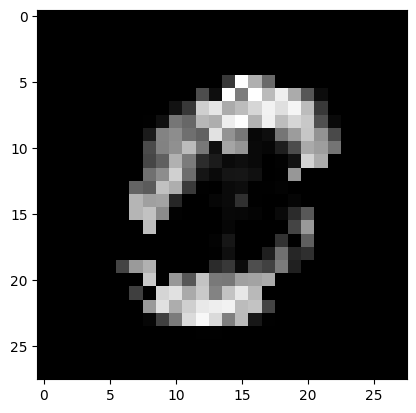

Discriminator real loss 0.24191269278526306
Discriminator fake loss 0.09838899970054626
Discriminator real loss 0.21039395034313202
Discriminator fake loss 0.13132677972316742
Generator loss 0.08821481466293335
Generator auxiliary loss 0.26020243763923645
Generator loss 0.10456224530935287
Generator auxiliary loss 0.25958263874053955
Generator loss 0.12235751748085022
Generator auxiliary loss 0.2597634494304657
0.024170074611902237


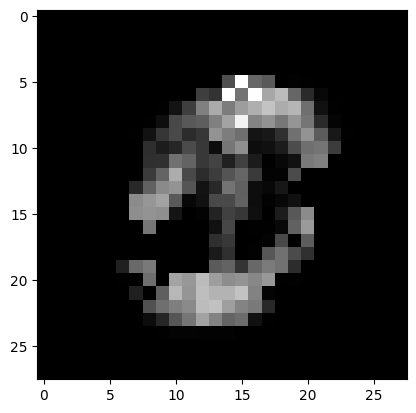

Discriminator real loss 0.23828521370887756
Discriminator fake loss 0.11341338604688644
Discriminator real loss 0.24551419913768768
Discriminator fake loss 0.09174398332834244
Generator loss 0.23354926705360413
Generator auxiliary loss 0.26166120171546936
Generator loss 0.16474579274654388
Generator auxiliary loss 0.2610170245170593
Generator loss 0.08254716545343399
Generator auxiliary loss 0.2605838477611542
0.09209753572940826


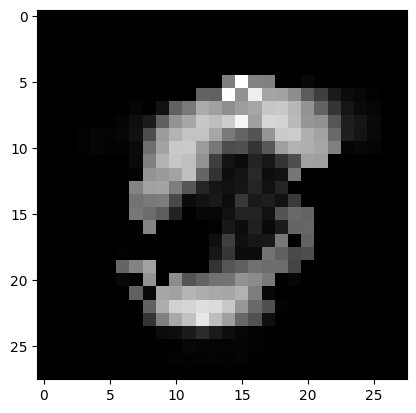

Discriminator real loss 0.2889140844345093
Discriminator fake loss 0.10091391205787659
Discriminator real loss 0.258882611989975
Discriminator fake loss 0.10456222295761108
Generator loss 0.12360615283250809
Generator auxiliary loss 0.2547558844089508
Generator loss 0.09963385760784149
Generator auxiliary loss 0.25454050302505493
Generator loss 0.097048319876194
Generator auxiliary loss 0.2545759975910187
0.28066012263298035


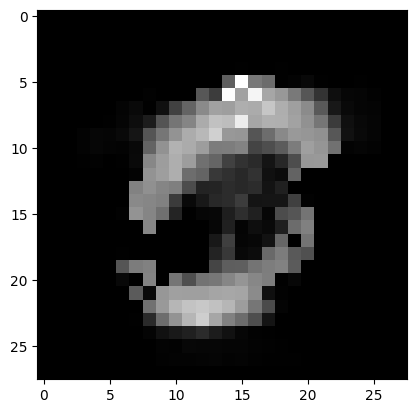

Discriminator real loss 0.22291266918182373
Discriminator fake loss 0.09153123199939728
Discriminator real loss 0.21327412128448486
Discriminator fake loss 0.10607512295246124
Generator loss 0.1663750559091568
Generator auxiliary loss 0.25540682673454285
Generator loss 0.10677971690893173
Generator auxiliary loss 0.2547028958797455
0.12457217276096344


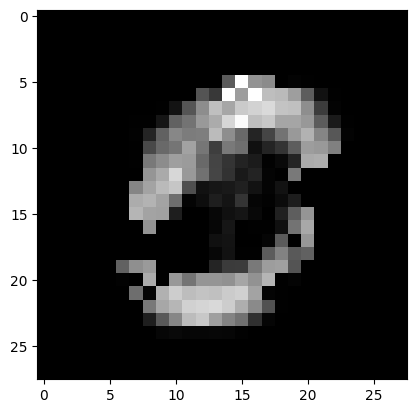

Discriminator real loss 0.21836639940738678
Discriminator fake loss 0.11948803812265396
Discriminator real loss 0.22288666665554047
Discriminator fake loss 0.0999140590429306
Generator loss 0.10443728417158127
Generator auxiliary loss 0.2528195083141327
Generator loss 0.11082163453102112
Generator auxiliary loss 0.2528398036956787
0.026222074404358864


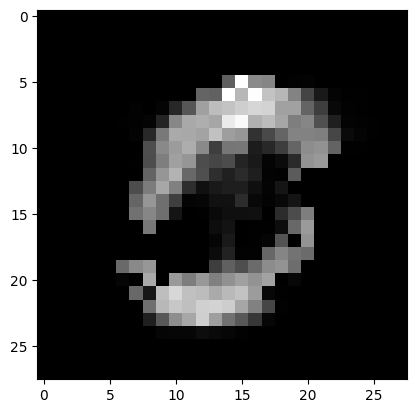

Discriminator real loss 0.2532636225223541
Discriminator fake loss 0.09791427850723267
Discriminator real loss 0.25846371054649353
Discriminator fake loss 0.12516334652900696
Generator loss 0.1687873899936676
Generator auxiliary loss 0.25170281529426575
Generator loss 0.12826499342918396
Generator auxiliary loss 0.2511533796787262
Generator loss 0.10667193681001663
Generator auxiliary loss 0.2532985210418701
0.07078100740909576


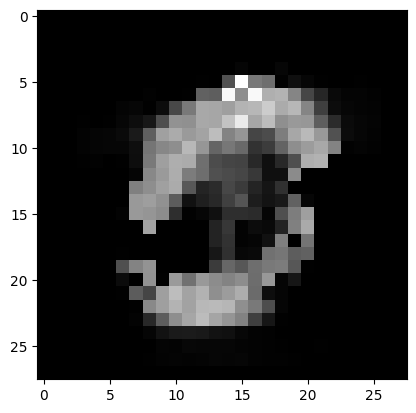

Discriminator real loss 0.24881847202777863
Discriminator fake loss 0.11835569888353348
Discriminator real loss 0.24804429709911346
Discriminator fake loss 0.10298553109169006
Generator loss 0.09049765020608902
Generator auxiliary loss 0.25607746839523315
Generator loss 0.08981872349977493
Generator auxiliary loss 0.2552335560321808
Generator loss 0.09412665665149689
Generator auxiliary loss 0.25685107707977295
0.10968790203332901


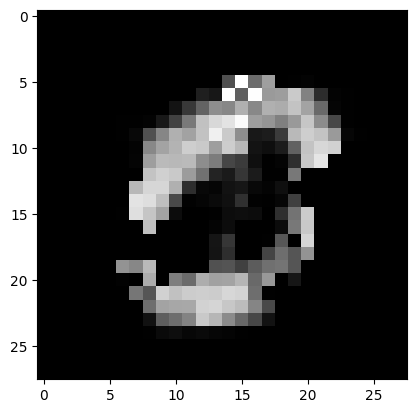

Discriminator real loss 0.2857935428619385
Discriminator fake loss 0.12035088986158371
Discriminator real loss 0.24966217577457428
Discriminator fake loss 0.10756820440292358
Generator loss 0.07774998992681503
Generator auxiliary loss 0.25711381435394287
Generator loss 0.11411134898662567
Generator auxiliary loss 0.2569042444229126
0.0967906191945076


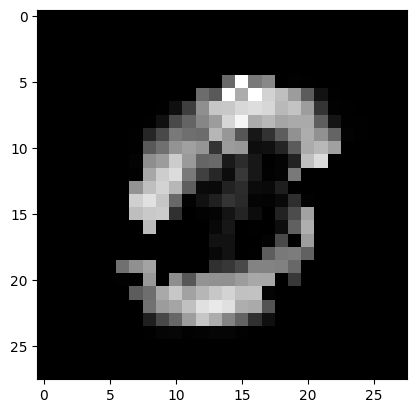

Discriminator real loss 0.2355513870716095
Discriminator fake loss 0.11824622005224228
Discriminator real loss 0.21196702122688293
Discriminator fake loss 0.0799853578209877
Generator loss 0.10480890423059464
Generator auxiliary loss 0.25431036949157715
Generator loss 0.10439079999923706
Generator auxiliary loss 0.2554103136062622
Generator loss 0.12026295065879822
Generator auxiliary loss 0.2546180188655853
0.04509411379694939


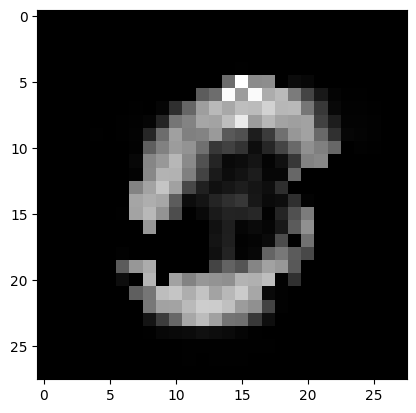

Discriminator real loss 0.24035762250423431
Discriminator fake loss 0.11552166938781738
Discriminator real loss 0.21334527432918549
Discriminator fake loss 0.09643565863370895
Generator loss 0.16253462433815002
Generator auxiliary loss 0.254827082157135
Generator loss 0.09862674027681351
Generator auxiliary loss 0.2546291649341583
Generator loss 0.10974638164043427
Generator auxiliary loss 0.25531190633773804
0.040763016790151596


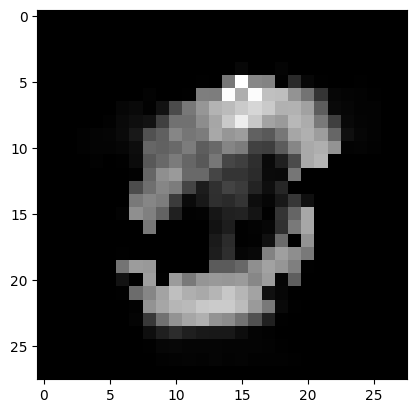

Discriminator real loss 0.25705456733703613
Discriminator fake loss 0.09108133614063263
Discriminator real loss 0.22010576725006104
Discriminator fake loss 0.10050531476736069
Generator loss 0.12018610537052155
Generator auxiliary loss 0.25540584325790405
Generator loss 0.13780739903450012
Generator auxiliary loss 0.25471606850624084
Generator loss 0.09688876569271088
Generator auxiliary loss 0.2543012201786041
0.21819095313549042


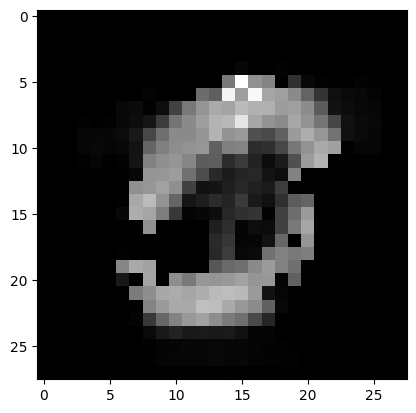

Discriminator real loss 0.18436016142368317
Discriminator fake loss 0.10001983493566513
Discriminator real loss 0.18429884314537048
Discriminator fake loss 0.10028266906738281
Generator loss 0.08022009581327438
Generator auxiliary loss 0.24466603994369507
Generator loss 0.09028985351324081
Generator auxiliary loss 0.24446170032024384
0.15756770968437195


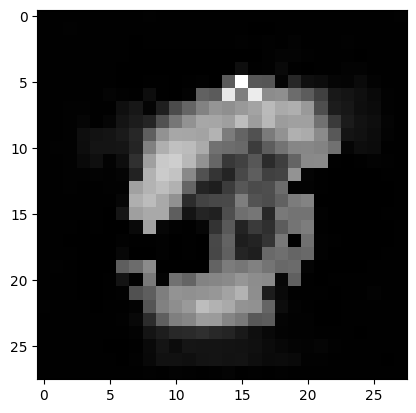

Discriminator real loss 0.24611447751522064
Discriminator fake loss 0.11083319038152695
Discriminator real loss 0.20515412092208862
Discriminator fake loss 0.08306846767663956
Generator loss 0.08809597790241241
Generator auxiliary loss 0.2538614869117737
Generator loss 0.10406587272882462
Generator auxiliary loss 0.2547561824321747
0.030137166380882263


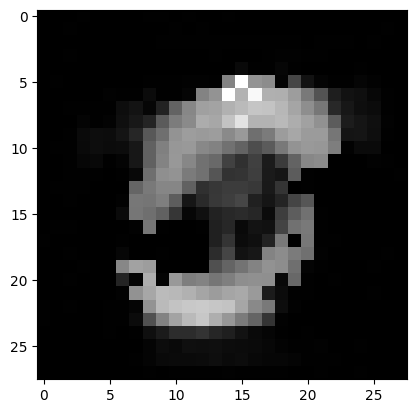

Discriminator real loss 0.17963650822639465
Discriminator fake loss 0.08420451730489731
Discriminator real loss 0.1693020910024643
Discriminator fake loss 0.08701995015144348
Generator loss 0.11166299134492874
Generator auxiliary loss 0.24868741631507874
Generator loss 0.1065685972571373
Generator auxiliary loss 0.2487514764070511
Generator loss 0.09014655649662018
Generator auxiliary loss 0.24849611520767212
0.1003803014755249


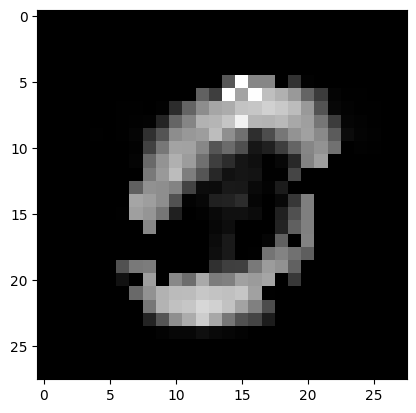

Discriminator real loss 0.2576397955417633
Discriminator fake loss 0.08659020811319351
Discriminator real loss 0.17244301736354828
Discriminator fake loss 0.08682136982679367
Generator loss 0.0941815972328186
Generator auxiliary loss 0.2552621066570282
Generator loss 0.1197054386138916
Generator auxiliary loss 0.2554141581058502
0.048412106931209564


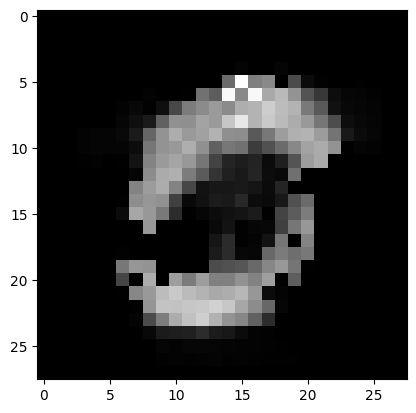

Discriminator real loss 0.196397066116333
Discriminator fake loss 0.08459953963756561
Discriminator real loss 0.19074732065200806
Discriminator fake loss 0.09517082571983337
Generator loss 0.10210803151130676
Generator auxiliary loss 0.2553483247756958
Generator loss 0.08151853829622269
Generator auxiliary loss 0.2526848018169403
Generator loss 0.07949946820735931
Generator auxiliary loss 0.25332722067832947
0.13338080048561096


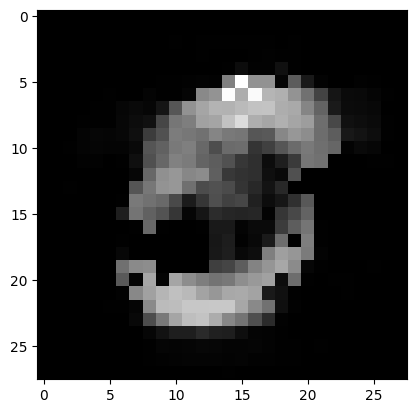

Discriminator real loss 0.28290820121765137
Discriminator fake loss 0.10066885501146317
Discriminator real loss 0.1978839635848999
Discriminator fake loss 0.06856948137283325
Generator loss 0.10270267724990845
Generator auxiliary loss 0.250047504901886
Generator loss 0.09045293182134628
Generator auxiliary loss 0.24939952790737152
0.0057530589401721954


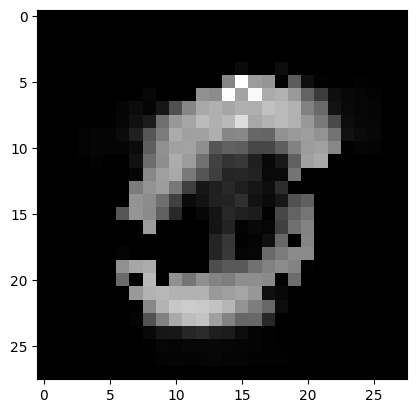

Discriminator real loss 0.2335938960313797
Discriminator fake loss 0.09149094671010971
Discriminator real loss 0.28146836161613464
Discriminator fake loss 0.09569944441318512
Generator loss 0.07204753160476685
Generator auxiliary loss 0.24782095849514008
Generator loss 0.10575041174888611
Generator auxiliary loss 0.24733299016952515
Generator loss 0.07599101960659027
Generator auxiliary loss 0.24777467548847198
0.06812071800231934


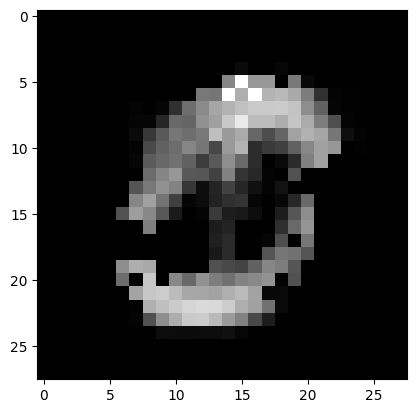

Discriminator real loss 0.2323559671640396
Discriminator fake loss 0.11158134043216705
Discriminator real loss 0.17578135430812836
Discriminator fake loss 0.08075102418661118
Generator loss 0.09199818968772888
Generator auxiliary loss 0.25504952669143677
Generator loss 0.09469345957040787
Generator auxiliary loss 0.25549182295799255
Generator loss 0.09190229326486588
Generator auxiliary loss 0.255669504404068
0.007701330818235874


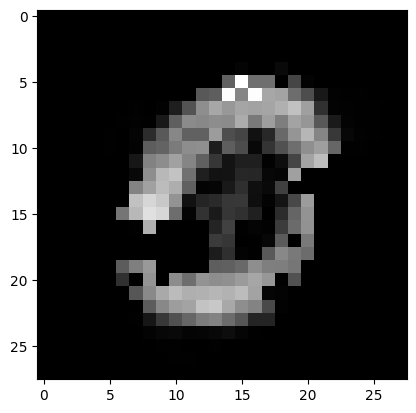

Discriminator real loss 0.19949275255203247
Discriminator fake loss 0.09502636641263962
Discriminator real loss 0.21190448105335236
Discriminator fake loss 0.09658756852149963
Generator loss 0.08210521936416626
Generator auxiliary loss 0.2535945773124695
Generator loss 0.07975325733423233
Generator auxiliary loss 0.2535725235939026
Generator loss 0.11425449699163437
Generator auxiliary loss 0.25388091802597046
0.010847067460417747


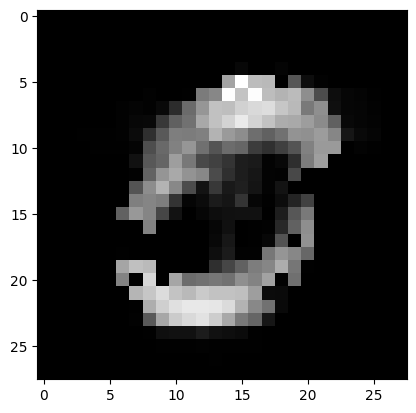

Discriminator real loss 0.23841655254364014
Discriminator fake loss 0.08569248020648956
Discriminator real loss 0.2128419429063797
Discriminator fake loss 0.07197228074073792
Generator loss 0.08459071815013885
Generator auxiliary loss 0.25522658228874207
Generator loss 0.09084312617778778
Generator auxiliary loss 0.2541240155696869
Generator loss 0.07153531908988953
Generator auxiliary loss 0.2545553147792816
0.05882668495178223


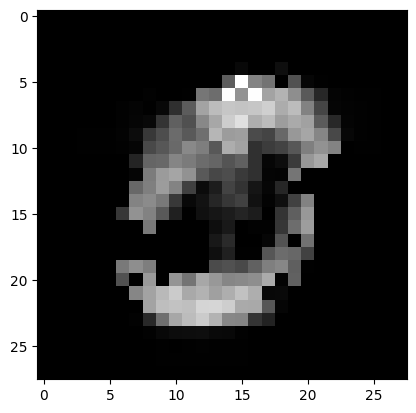

Discriminator real loss 0.2383306473493576
Discriminator fake loss 0.09102572500705719
Discriminator real loss 0.17952705919742584
Discriminator fake loss 0.08578313142061234
Generator loss 0.07490704208612442
Generator auxiliary loss 0.2537948787212372
Generator loss 0.10292039066553116
Generator auxiliary loss 0.2529306411743164
Generator loss 0.0852399468421936
Generator auxiliary loss 0.2538682222366333
0.030001113191246986


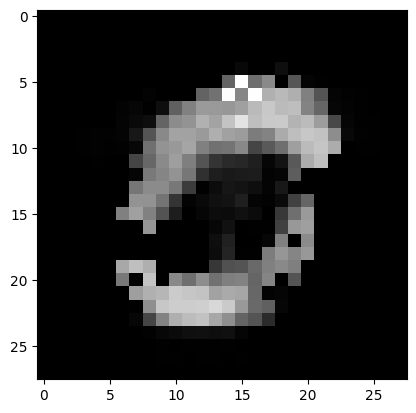

Discriminator real loss 0.22285355627536774
Discriminator fake loss 0.0488281287252903
Discriminator real loss 0.2178611308336258
Discriminator fake loss 0.13133671879768372
Generator loss 0.06617703288793564
Generator auxiliary loss 0.24207402765750885
Generator loss 0.0750618726015091
Generator auxiliary loss 0.24226076900959015
Generator loss 0.07692603021860123
Generator auxiliary loss 0.24243594706058502
0.18071265518665314


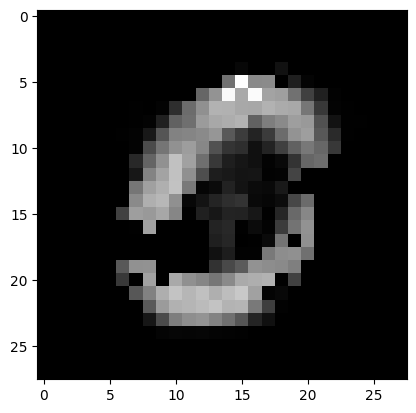

Discriminator real loss 0.18559673428535461
Discriminator fake loss 0.06785368919372559
Discriminator real loss 0.21124877035617828
Discriminator fake loss 0.09181145578622818
Generator loss 0.09379635006189346
Generator auxiliary loss 0.2476193755865097
Generator loss 0.06483618170022964
Generator auxiliary loss 0.2479543834924698
0.13040119409561157


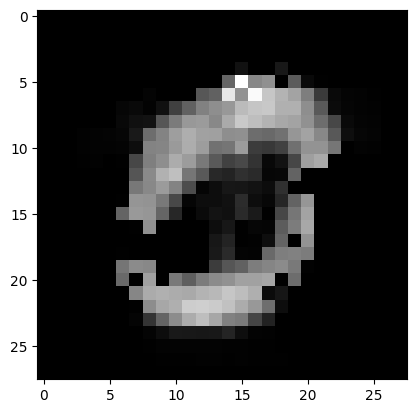

Discriminator real loss 0.20451317727565765
Discriminator fake loss 0.06654041260480881
Discriminator real loss 0.17805826663970947
Discriminator fake loss 0.08852984756231308
Generator loss 0.06880571693181992
Generator auxiliary loss 0.2423059493303299
Generator loss 0.08004429936408997
Generator auxiliary loss 0.2418893426656723
0.1633416712284088


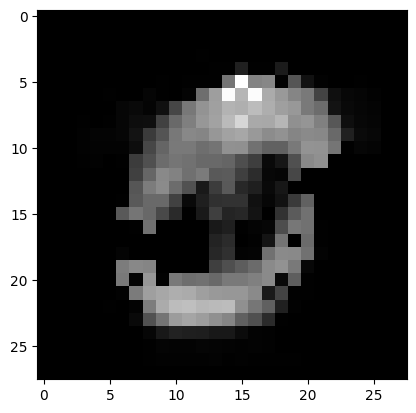

Discriminator real loss 0.19072496891021729
Discriminator fake loss 0.05399958789348602
Discriminator real loss 0.1723145991563797
Discriminator fake loss 0.07340861856937408
Generator loss 0.08572199195623398
Generator auxiliary loss 0.2530289590358734
Generator loss 0.09539526700973511
Generator auxiliary loss 0.2528931200504303
0.05572758987545967


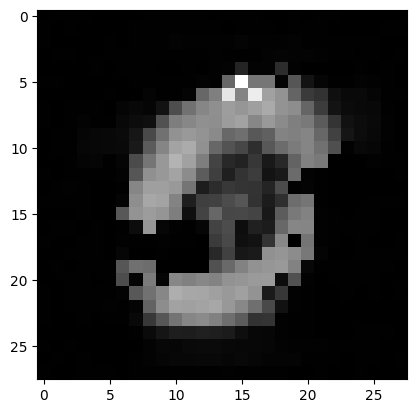

Discriminator real loss 0.21805183589458466
Discriminator fake loss 0.0937662422657013
Discriminator real loss 0.21104174852371216
Discriminator fake loss 0.08809187263250351
Generator loss 0.08350665867328644
Generator auxiliary loss 0.24971917271614075
Generator loss 0.07235166430473328
Generator auxiliary loss 0.24922765791416168
Generator loss 0.07787344604730606
Generator auxiliary loss 0.25051745772361755
0.02175128273665905


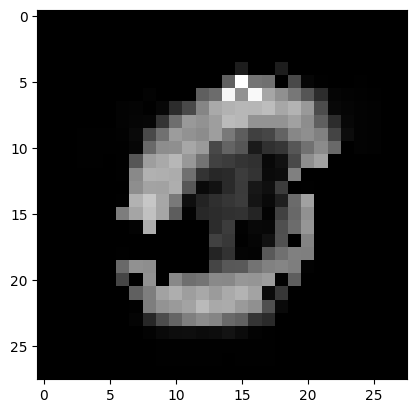

Discriminator real loss 0.23011787235736847
Discriminator fake loss 0.08977481722831726
Discriminator real loss 0.2436128705739975
Discriminator fake loss 0.07415001839399338
Generator loss 0.07924129068851471
Generator auxiliary loss 0.25002506375312805
Generator loss 0.06905176490545273
Generator auxiliary loss 0.25041308999061584
Generator loss 0.06413892656564713
Generator auxiliary loss 0.24993214011192322
0.10351995378732681


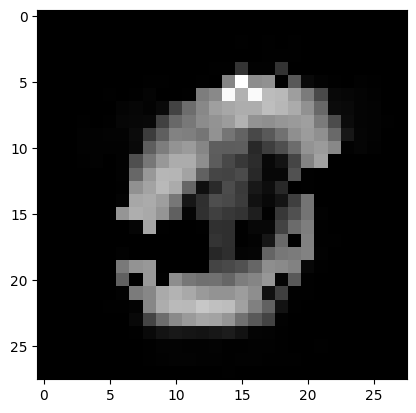

Discriminator real loss 0.17007280886173248
Discriminator fake loss 0.08615487813949585
Discriminator real loss 0.1559200882911682
Discriminator fake loss 0.09068018198013306
Generator loss 0.12427794188261032
Generator auxiliary loss 0.24526773393154144
Generator loss 0.05012921988964081
Generator auxiliary loss 0.24452759325504303
0.016941174864768982


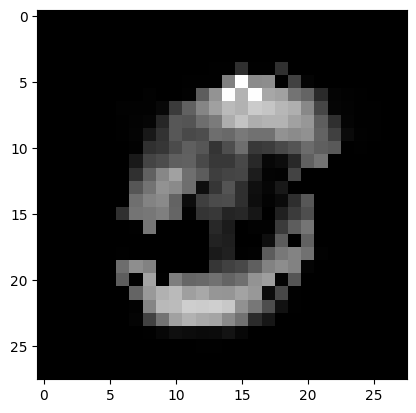

Discriminator real loss 0.19632956385612488
Discriminator fake loss 0.0862986370921135
Discriminator real loss 0.18940302729606628
Discriminator fake loss 0.08282861113548279
Generator loss 0.06621959060430527
Generator auxiliary loss 0.24698218703269958
Generator loss 0.09404923766851425
Generator auxiliary loss 0.24680490791797638
Generator loss 0.06861501932144165
Generator auxiliary loss 0.24745570123195648
0.07103867828845978


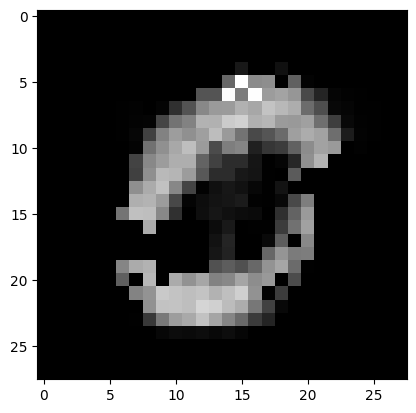

Discriminator real loss 0.20826153457164764
Discriminator fake loss 0.09271202236413956
Discriminator real loss 0.28709712624549866
Discriminator fake loss 0.07591798156499863
Generator loss 0.06884260475635529
Generator auxiliary loss 0.2446928471326828
Generator loss 0.09017789363861084
Generator auxiliary loss 0.24417945742607117
Generator loss 0.05501960590481758
Generator auxiliary loss 0.24444033205509186
0.015012606978416443


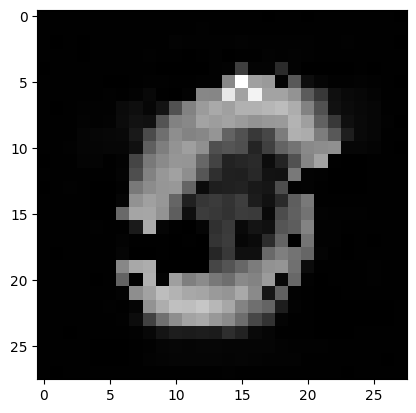

Discriminator real loss 0.18995219469070435
Discriminator fake loss 0.057283785194158554
Discriminator real loss 0.25878167152404785
Discriminator fake loss 0.05808350443840027
Generator loss 0.15058273077011108
Generator auxiliary loss 0.2465043067932129
Generator loss 0.07459759712219238
Generator auxiliary loss 0.245999276638031
Generator loss 0.09182713180780411
Generator auxiliary loss 0.24663051962852478
0.06644914299249649


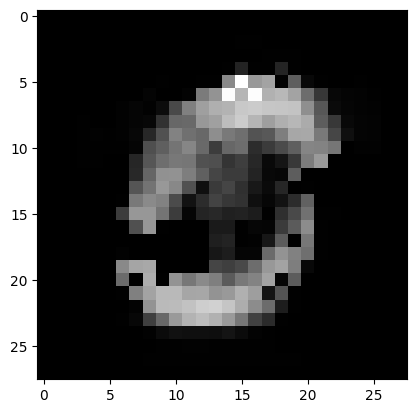

Discriminator real loss 0.15408508479595184
Discriminator fake loss 0.06669046729803085
Discriminator real loss 0.1621624380350113
Discriminator fake loss 0.14051605761051178
Generator loss 0.05492296814918518
Generator auxiliary loss 0.24673818051815033
Generator loss 0.0691174864768982
Generator auxiliary loss 0.24567590653896332
Generator loss 0.07444029301404953
Generator auxiliary loss 0.2461276650428772
0.05147653818130493


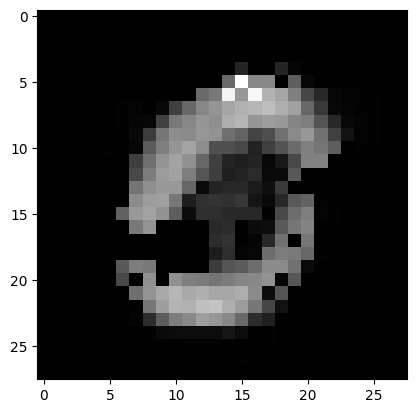

Discriminator real loss 0.1720319241285324
Discriminator fake loss 0.07138654589653015
Discriminator real loss 0.18316291272640228
Discriminator fake loss 0.06572794169187546
Generator loss 0.09768526256084442
Generator auxiliary loss 0.24782432615756989
Generator loss 0.06171969324350357
Generator auxiliary loss 0.24877317249774933
Generator loss 0.08966779708862305
Generator auxiliary loss 0.24879343807697296
0.016631802543997765


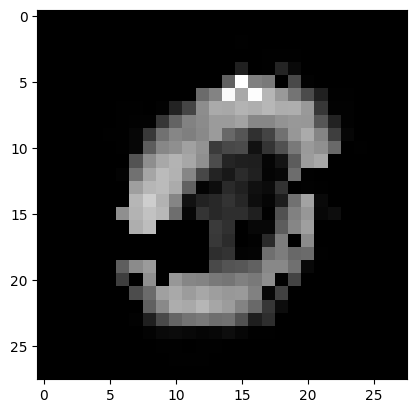

Discriminator real loss 0.16540975868701935
Discriminator fake loss 0.06601360440254211
Discriminator real loss 0.12978112697601318
Discriminator fake loss 0.08977033942937851
Generator loss 0.09103246033191681
Generator auxiliary loss 0.23986908793449402
Generator loss 0.08029109239578247
Generator auxiliary loss 0.23976947367191315
Generator loss 0.08507808297872543
Generator auxiliary loss 0.24060451984405518
0.029885202646255493


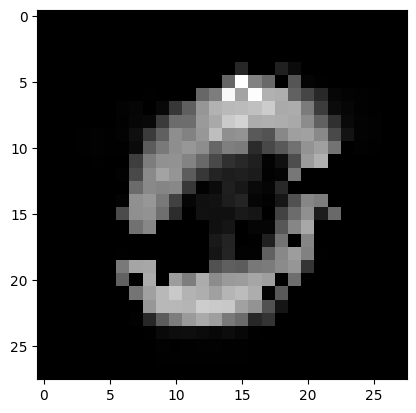

Discriminator real loss 0.1452869176864624
Discriminator fake loss 0.07245685905218124
Discriminator real loss 0.18317432701587677
Discriminator fake loss 0.05713802948594093
Generator loss 0.07103420048952103
Generator auxiliary loss 0.24441052973270416
Generator loss 0.08004260808229446
Generator auxiliary loss 0.2442232370376587
Generator loss 0.07764734327793121
Generator auxiliary loss 0.24457228183746338
0.13831670582294464


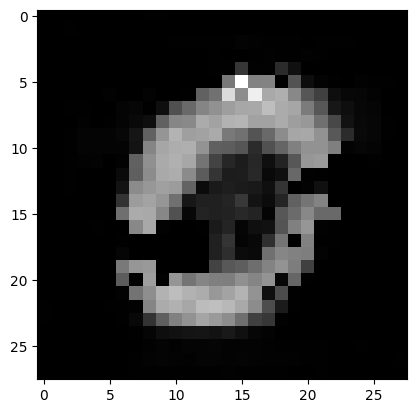

Discriminator real loss 0.1426447182893753
Discriminator fake loss 0.06306076049804688
Discriminator real loss 0.14489294588565826
Discriminator fake loss 0.07748968154191971
Generator loss 0.06498564034700394
Generator auxiliary loss 0.25047510862350464
Generator loss 0.09867431968450546
Generator auxiliary loss 0.25048425793647766
0.18780171871185303


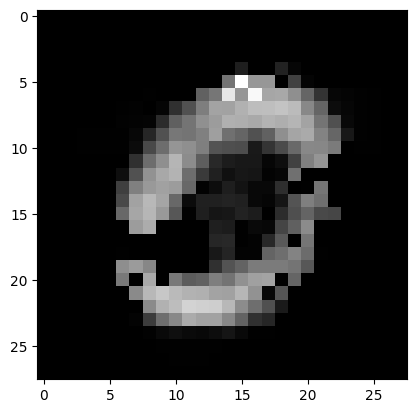

Discriminator real loss 0.3049347400665283
Discriminator fake loss 0.09291829913854599
Discriminator real loss 0.16467247903347015
Discriminator fake loss 0.0834898054599762
Generator loss 0.0764821469783783
Generator auxiliary loss 0.246177077293396
Generator loss 0.0919862762093544
Generator auxiliary loss 0.24500401318073273
0.06914443522691727


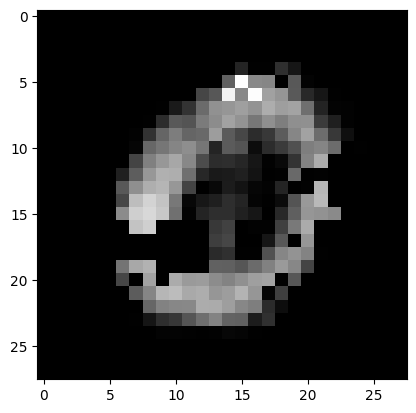

Discriminator real loss 0.2221527099609375
Discriminator fake loss 0.08772803097963333
Discriminator real loss 0.16334450244903564
Discriminator fake loss 0.06240239366889
Generator loss 0.094051793217659
Generator auxiliary loss 0.24076281487941742
Generator loss 0.06893172115087509
Generator auxiliary loss 0.24132946133613586
Generator loss 0.10236064344644547
Generator auxiliary loss 0.24134783446788788
0.015219246037304401


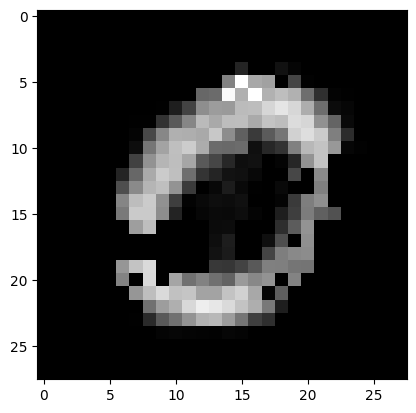

Discriminator real loss 0.13831524550914764
Discriminator fake loss 0.07447018474340439
Discriminator real loss 0.3586902320384979
Discriminator fake loss 0.05436267331242561
Generator loss 0.0701688826084137
Generator auxiliary loss 0.2415437400341034
Generator loss 0.06291621923446655
Generator auxiliary loss 0.24071849882602692
Generator loss 0.07549649477005005
Generator auxiliary loss 0.2408582866191864
0.07412464171648026


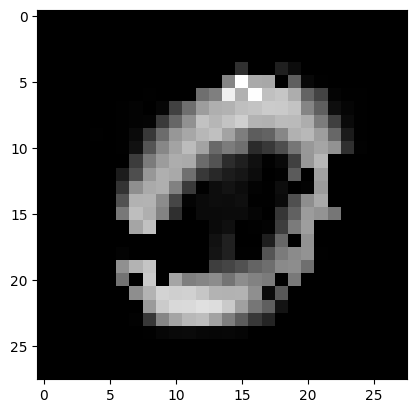

Discriminator real loss 0.24879372119903564
Discriminator fake loss 0.06288439780473709
Discriminator real loss 0.24011200666427612
Discriminator fake loss 0.0701664388179779
Generator loss 0.06327611207962036
Generator auxiliary loss 0.24962984025478363
Generator loss 0.11297598481178284
Generator auxiliary loss 0.25079548358917236
Generator loss 0.08082696050405502
Generator auxiliary loss 0.25024232268333435
0.25880420207977295


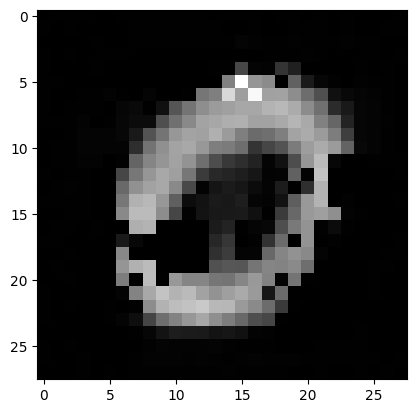

Discriminator real loss 0.11147389560937881
Discriminator fake loss 0.08490578085184097
Discriminator real loss 0.15371102094650269
Discriminator fake loss 0.06753312796354294
Generator loss 0.06236337497830391
Generator auxiliary loss 0.2451658695936203
Generator loss 0.09594488888978958
Generator auxiliary loss 0.24528628587722778
0.06669071316719055


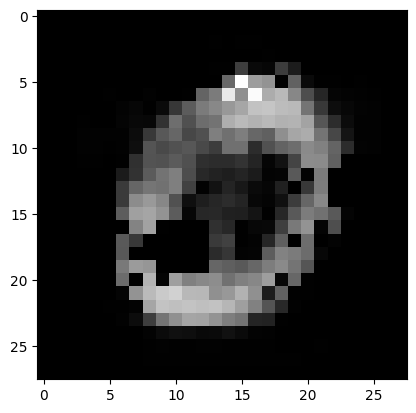

Discriminator real loss 0.1936061680316925
Discriminator fake loss 0.06316682696342468
Discriminator real loss 0.148566335439682
Discriminator fake loss 0.04570494964718819
Generator loss 0.08797384798526764
Generator auxiliary loss 0.24546165764331818
Generator loss 0.08571456372737885
Generator auxiliary loss 0.24667145311832428
Generator loss 0.06684769690036774
Generator auxiliary loss 0.24627423286437988
0.0031932354904711246


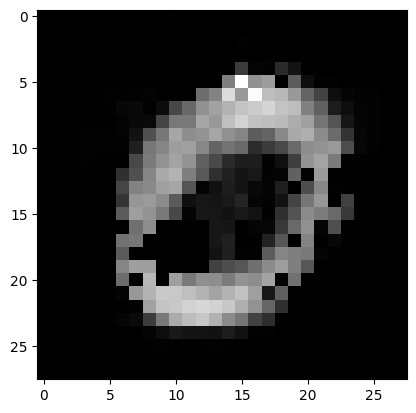

Discriminator real loss 0.16456030309200287
Discriminator fake loss 0.08117986470460892
Discriminator real loss 0.14435377717018127
Discriminator fake loss 0.061448611319065094
Generator loss 0.05304056778550148
Generator auxiliary loss 0.24099890887737274
Generator loss 0.07726507633924484
Generator auxiliary loss 0.24081912636756897
Generator loss 0.05755089968442917
Generator auxiliary loss 0.24144889414310455
0.002603548811748624


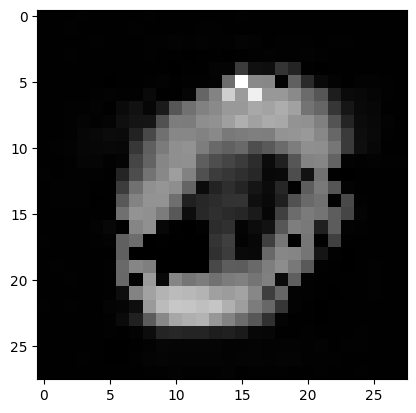

Discriminator real loss 0.18512944877147675
Discriminator fake loss 0.051539670675992966
Discriminator real loss 0.23436693847179413
Discriminator fake loss 0.08814464509487152
Generator loss 0.058943334966897964
Generator auxiliary loss 0.24979566037654877
Generator loss 0.08233673125505447
Generator auxiliary loss 0.2501339316368103
Generator loss 0.07492425292730331
Generator auxiliary loss 0.2501036822795868
0.12435922771692276


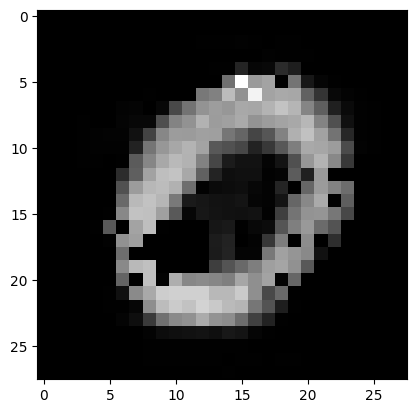

Discriminator real loss 0.16323916614055634
Discriminator fake loss 0.06685969233512878
Discriminator real loss 0.16738702356815338
Discriminator fake loss 0.07215574383735657
Generator loss 0.06881128996610641
Generator auxiliary loss 0.23987677693367004
Generator loss 0.06968940794467926
Generator auxiliary loss 0.23947517573833466
0.0032734298147261143


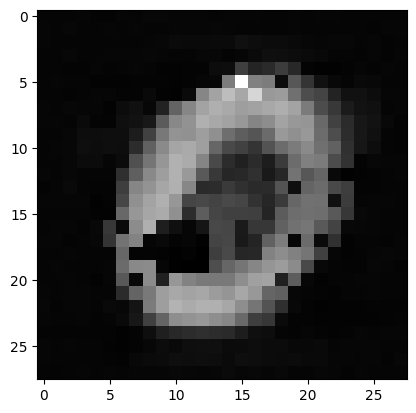

Discriminator real loss 0.15646931529045105
Discriminator fake loss 0.1243501678109169
Discriminator real loss 0.17378532886505127
Discriminator fake loss 0.05170273035764694
Generator loss 0.059540439397096634
Generator auxiliary loss 0.24133101105690002
Generator loss 0.10234738141298294
Generator auxiliary loss 0.2404252588748932
Generator loss 0.0680127665400505
Generator auxiliary loss 0.24013148248195648
0.052661508321762085


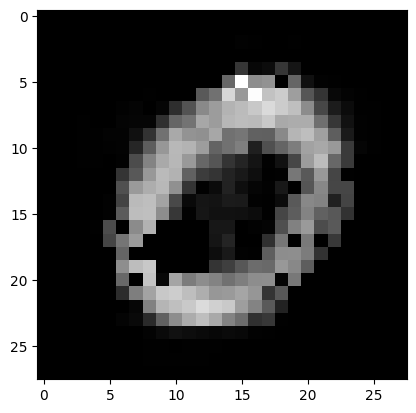

Discriminator real loss 0.1798560619354248
Discriminator fake loss 0.07401973009109497
Discriminator real loss 0.19634798169136047
Discriminator fake loss 0.060605645179748535
Generator loss 0.07502724975347519
Generator auxiliary loss 0.24276265501976013
Generator loss 0.10312788188457489
Generator auxiliary loss 0.24328617751598358
Generator loss 0.07604380697011948
Generator auxiliary loss 0.24257728457450867
0.017871256917715073


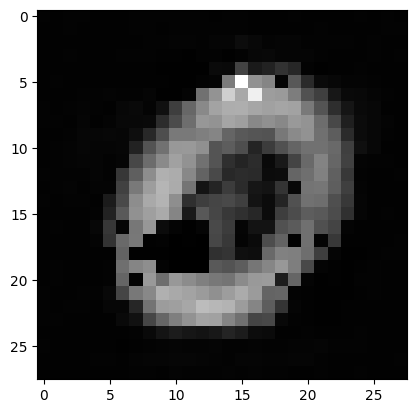

Discriminator real loss 0.18102453649044037
Discriminator fake loss 0.22127926349639893
Discriminator real loss 0.17727120220661163
Discriminator fake loss 0.04519912600517273
Generator loss 0.06354501843452454
Generator auxiliary loss 0.24423570930957794
Generator loss 0.06097875162959099
Generator auxiliary loss 0.24518176913261414
Generator loss 0.05100138112902641
Generator auxiliary loss 0.2446656972169876
0.04849357530474663


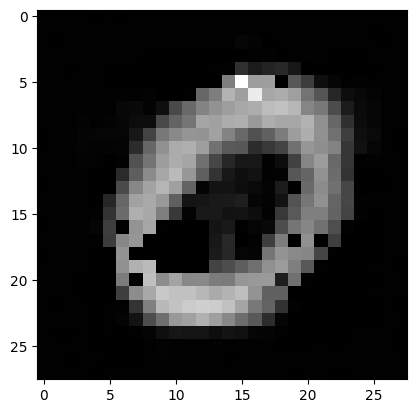

Discriminator real loss 0.13540218770503998
Discriminator fake loss 0.0639990046620369
Discriminator real loss 0.1055101752281189
Discriminator fake loss 0.041987013071775436
Generator loss 0.06680649518966675
Generator auxiliary loss 0.2363564521074295
Generator loss 0.06169678643345833
Generator auxiliary loss 0.23598486185073853
Generator loss 0.06157373636960983
Generator auxiliary loss 0.23532268404960632
0.002005164511501789


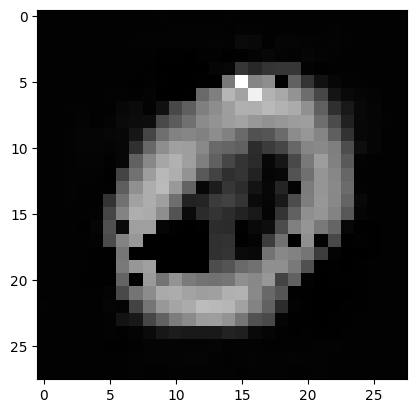

Discriminator real loss 0.15469776093959808
Discriminator fake loss 0.05756676197052002
Discriminator real loss 0.15864180028438568
Discriminator fake loss 0.0699474960565567
Generator loss 0.05334588140249252
Generator auxiliary loss 0.24040542542934418
Generator loss 0.07993069291114807
Generator auxiliary loss 0.23973482847213745
Generator loss 0.08138825744390488
Generator auxiliary loss 0.23933230340480804
0.051563818007707596


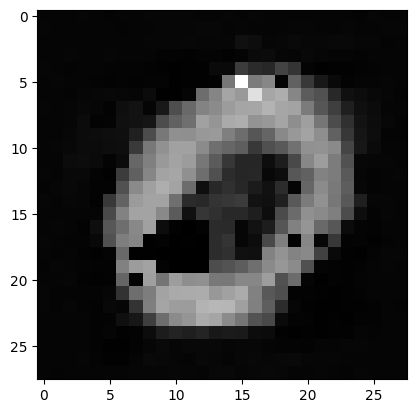

Discriminator real loss 0.15147928893566132
Discriminator fake loss 0.07130855321884155
Discriminator real loss 0.13995380699634552
Discriminator fake loss 0.06042139232158661
Generator loss 0.07428064197301865
Generator auxiliary loss 0.2385760396718979
Generator loss 0.06471437215805054
Generator auxiliary loss 0.23841147124767303
Generator loss 0.06410437822341919
Generator auxiliary loss 0.23921775817871094
0.012054461054503918


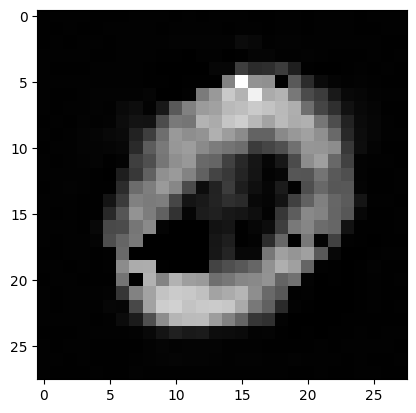

Discriminator real loss 0.2112843096256256
Discriminator fake loss 0.06420770287513733
Discriminator real loss 0.17644980549812317
Discriminator fake loss 0.059676527976989746
Generator loss 0.0509718656539917
Generator auxiliary loss 0.24356533586978912
Generator loss 0.07941226661205292
Generator auxiliary loss 0.2428232878446579
Generator loss 0.06758099049329758
Generator auxiliary loss 0.2430441677570343
0.047995321452617645


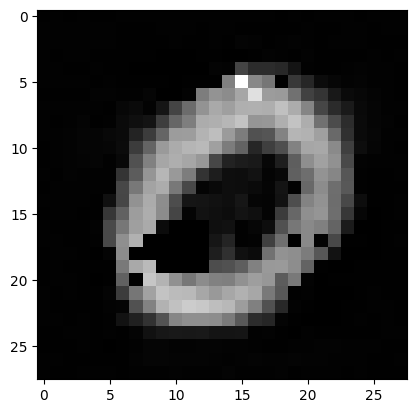

Discriminator real loss 0.2369529753923416
Discriminator fake loss 0.0956665650010109
Discriminator real loss 0.24702759087085724
Discriminator fake loss 0.05307728424668312
Generator loss 0.06632023304700851
Generator auxiliary loss 0.2431514859199524
Generator loss 0.0629846453666687
Generator auxiliary loss 0.2425818145275116
Generator loss 0.04698462784290314
Generator auxiliary loss 0.2430080771446228
0.004457311239093542


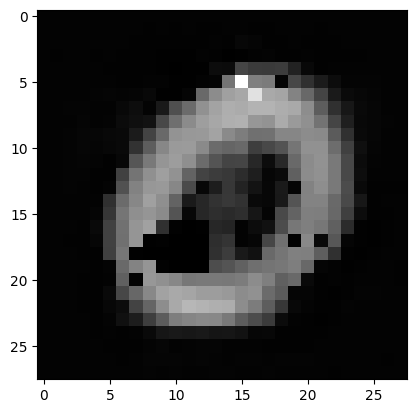

Discriminator real loss 0.1327873021364212
Discriminator fake loss 0.05851772055029869
Discriminator real loss 0.1319214254617691
Discriminator fake loss 0.07572273164987564
Generator loss 0.0911259800195694
Generator auxiliary loss 0.24556680023670197
Generator loss 0.04665037989616394
Generator auxiliary loss 0.24672958254814148
Generator loss 0.06250543147325516
Generator auxiliary loss 0.24594251811504364
0.1556890308856964


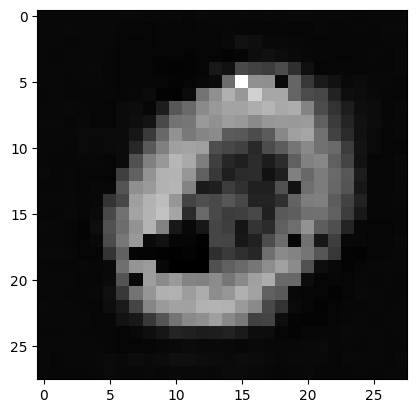

Discriminator real loss 0.18663692474365234
Discriminator fake loss 0.0917372927069664
Discriminator real loss 0.16845110058784485
Discriminator fake loss 0.07070159167051315
Generator loss 0.05571145936846733
Generator auxiliary loss 0.2398858666419983
Generator loss 0.054507963359355927
Generator auxiliary loss 0.23972541093826294
0.011325148865580559


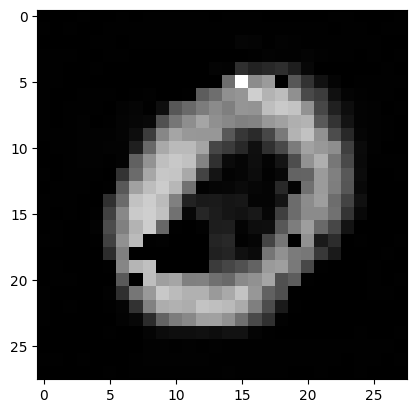

Discriminator real loss 0.14975135028362274
Discriminator fake loss 0.059942491352558136
Discriminator real loss 0.21250315010547638
Discriminator fake loss 0.0770241990685463
Generator loss 0.0623076967895031
Generator auxiliary loss 0.23888389766216278
Generator loss 0.06183215230703354
Generator auxiliary loss 0.23943489789962769
Generator loss 0.06531541794538498
Generator auxiliary loss 0.24048998951911926
0.0379110649228096


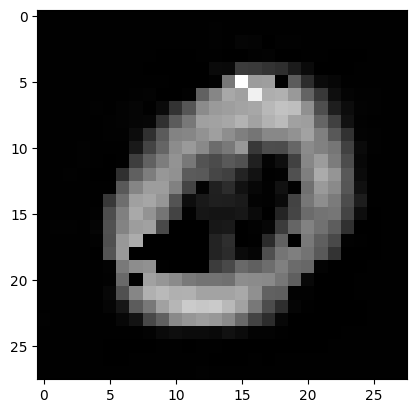

Discriminator real loss 0.13821196556091309
Discriminator fake loss 0.07626000791788101
Discriminator real loss 0.13543158769607544
Discriminator fake loss 0.08184296637773514
Generator loss 0.06599806994199753
Generator auxiliary loss 0.23879274725914001
Generator loss 0.08766534924507141
Generator auxiliary loss 0.23766079545021057
Generator loss 0.09469382464885712
Generator auxiliary loss 0.23810572922229767
0.023280451074242592


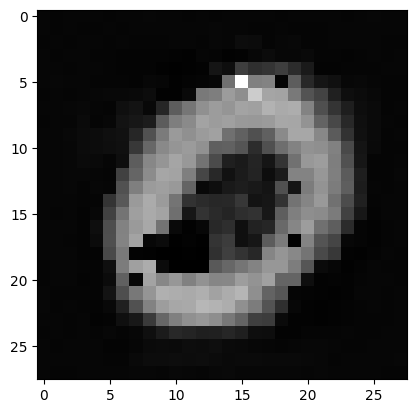

Discriminator real loss 0.14209720492362976
Discriminator fake loss 0.07459741085767746
Discriminator real loss 0.1768185794353485
Discriminator fake loss 0.05649678781628609
Generator loss 0.051289159804582596
Generator auxiliary loss 0.23874802887439728
Generator loss 0.06507162749767303
Generator auxiliary loss 0.23774471879005432
Generator loss 0.04800186678767204
Generator auxiliary loss 0.23782077431678772
0.09678928554058075


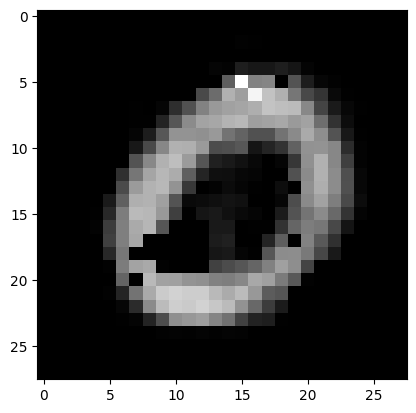

Discriminator real loss 0.128091499209404
Discriminator fake loss 0.04488197714090347
Discriminator real loss 0.18378625810146332
Discriminator fake loss 0.06603746116161346
Generator loss 0.056378237903118134
Generator auxiliary loss 0.23704124987125397
Generator loss 0.04968097433447838
Generator auxiliary loss 0.23681703209877014
Generator loss 0.05836227163672447
Generator auxiliary loss 0.23758594691753387
0.009744081646203995


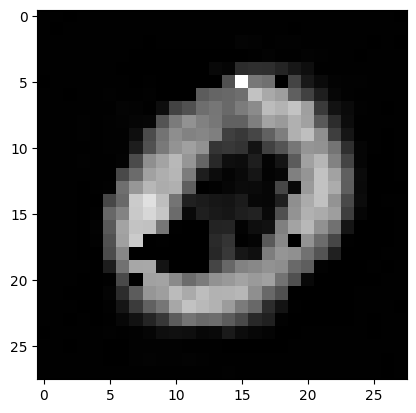

Discriminator real loss 0.17072005569934845
Discriminator fake loss 0.09661339223384857
Discriminator real loss 0.15058903396129608
Discriminator fake loss 0.07864224910736084
Generator loss 0.06302106380462646
Generator auxiliary loss 0.238541841506958
Generator loss 0.05380048230290413
Generator auxiliary loss 0.23891593515872955
Generator loss 0.052695419639348984
Generator auxiliary loss 0.23971636593341827
0.054357122629880905


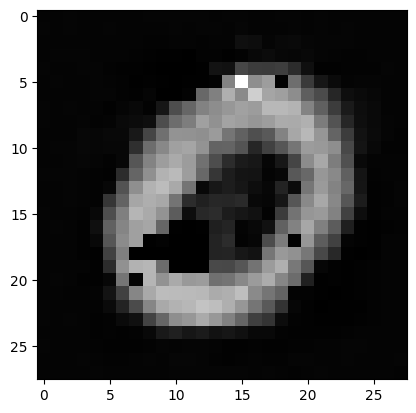

Discriminator real loss 0.13701075315475464
Discriminator fake loss 0.0658782497048378
Discriminator real loss 0.11810451000928879
Discriminator fake loss 0.044845834374427795
Generator loss 0.05369328707456589
Generator auxiliary loss 0.2389567345380783
Generator loss 0.047095656394958496
Generator auxiliary loss 0.23950445652008057
Generator loss 0.0780009999871254
Generator auxiliary loss 0.23935537040233612
0.13456639647483826


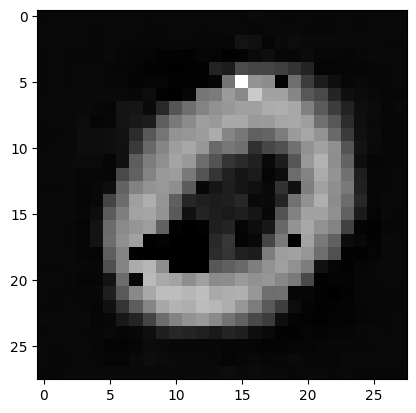

Discriminator real loss 0.13469457626342773
Discriminator fake loss 0.06743020564317703
Discriminator real loss 0.13604308664798737
Discriminator fake loss 0.046066951006650925
Generator loss 0.07879714667797089
Generator auxiliary loss 0.23533983528614044
Generator loss 0.07467316091060638
Generator auxiliary loss 0.23481148481369019
0.1005825623869896


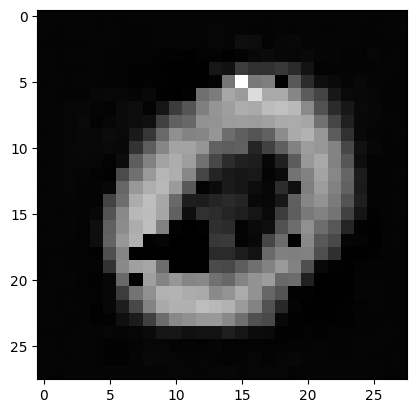

Discriminator real loss 0.18672403693199158
Discriminator fake loss 0.06952238827943802
Discriminator real loss 0.15260368585586548
Discriminator fake loss 0.06838016957044601
Generator loss 0.05036645010113716
Generator auxiliary loss 0.23741720616817474
Generator loss 0.15735416114330292
Generator auxiliary loss 0.23721157014369965
0.031188568100333214


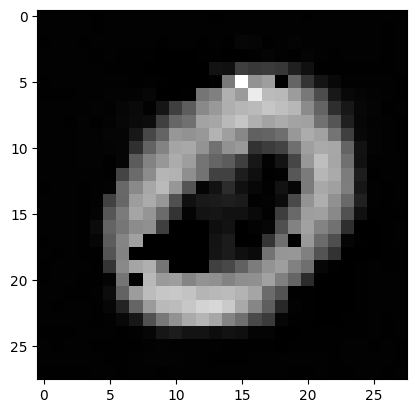

Discriminator real loss 0.1927948296070099
Discriminator fake loss 0.05889236181974411
Discriminator real loss 0.14067716896533966
Discriminator fake loss 0.052639659494161606
Generator loss 0.08986999839544296
Generator auxiliary loss 0.23372666537761688
Generator loss 0.04920227453112602
Generator auxiliary loss 0.23428381979465485
Generator loss 0.05758823826909065
Generator auxiliary loss 0.23407196998596191
0.005681435111910105


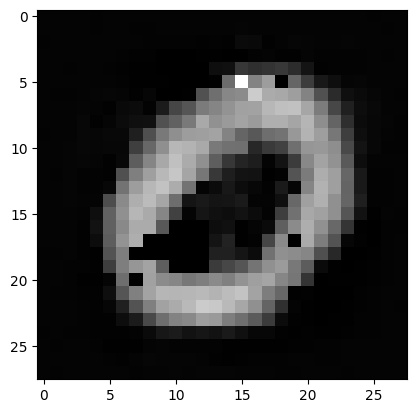

Discriminator real loss 0.1517990529537201
Discriminator fake loss 0.05002177879214287
Discriminator real loss 0.13524086773395538
Discriminator fake loss 0.06945769488811493
Generator loss 0.05703559145331383
Generator auxiliary loss 0.24010337889194489
Generator loss 0.04717007651925087
Generator auxiliary loss 0.23834681510925293
Generator loss 0.05920090153813362
Generator auxiliary loss 0.23841489851474762
0.016456153243780136


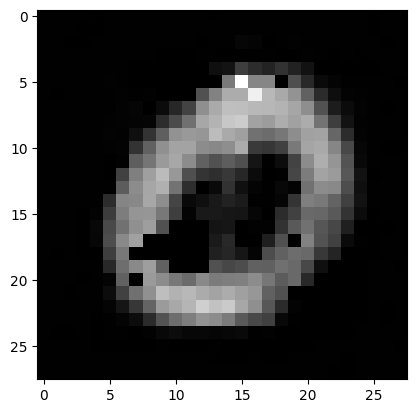

Discriminator real loss 0.10879514366388321
Discriminator fake loss 0.09665534645318985
Discriminator real loss 0.12492218613624573
Discriminator fake loss 0.06750772893428802
Generator loss 0.07728433609008789
Generator auxiliary loss 0.23657575249671936
Generator loss 0.06364043056964874
Generator auxiliary loss 0.23675288259983063
Generator loss 0.103532575070858
Generator auxiliary loss 0.23670755326747894
0.03564363718032837


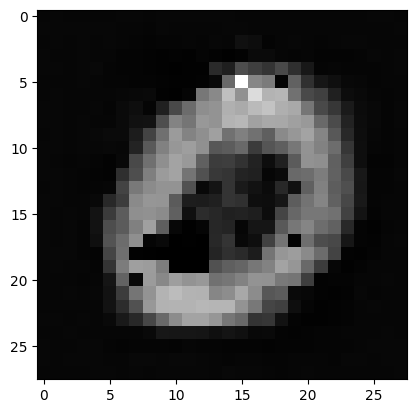

Discriminator real loss 0.11014226824045181
Discriminator fake loss 0.055879876017570496
Discriminator real loss 0.11856741458177567
Discriminator fake loss 0.05870237946510315
Generator loss 0.05103197321295738
Generator auxiliary loss 0.22766384482383728
Generator loss 0.04881491884589195
Generator auxiliary loss 0.2280571460723877
Generator loss 0.09321052581071854
Generator auxiliary loss 0.22925451397895813
0.003422373905777931


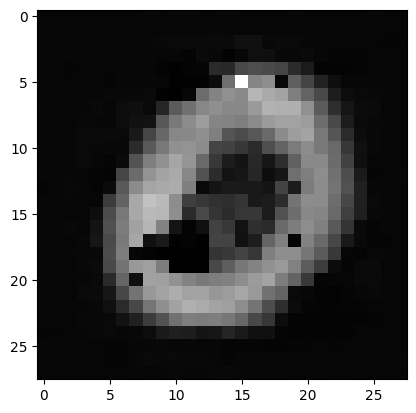

Discriminator real loss 0.15183866024017334
Discriminator fake loss 0.04427855461835861
Discriminator real loss 0.18936105072498322
Discriminator fake loss 0.0829780325293541
Generator loss 0.06840137392282486
Generator auxiliary loss 0.23914243280887604
Generator loss 0.06286942213773727
Generator auxiliary loss 0.23899933695793152
Generator loss 0.07990618050098419
Generator auxiliary loss 0.23944927752017975
0.00573346484452486


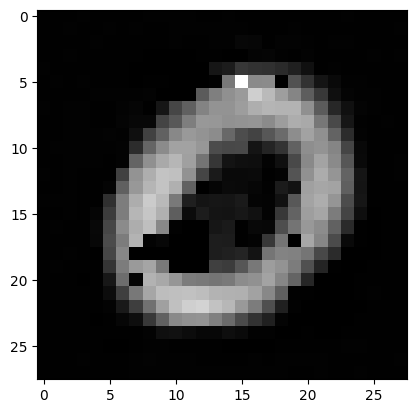

Discriminator real loss 0.1550627499818802
Discriminator fake loss 0.05082805082201958
Discriminator real loss 0.16762128472328186
Discriminator fake loss 0.05836155638098717
Generator loss 0.0690106600522995
Generator auxiliary loss 0.23811964690685272
Generator loss 0.08903837203979492
Generator auxiliary loss 0.23867283761501312
Generator loss 0.061987388879060745
Generator auxiliary loss 0.23840521275997162
0.020959215238690376


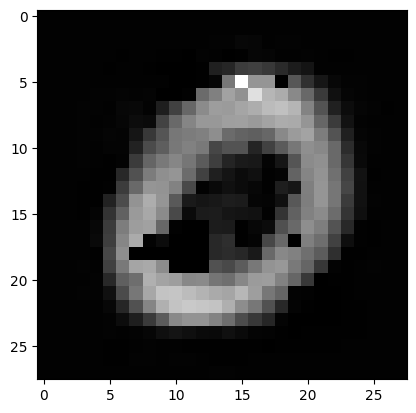

Discriminator real loss 0.14314459264278412
Discriminator fake loss 0.068317711353302
Discriminator real loss 0.11385335773229599
Discriminator fake loss 0.04788346216082573
Generator loss 0.07176392525434494
Generator auxiliary loss 0.2364174723625183
Generator loss 0.04273499175906181
Generator auxiliary loss 0.23694732785224915
Generator loss 0.06015492603182793
Generator auxiliary loss 0.23639068007469177
0.0019550099968910217


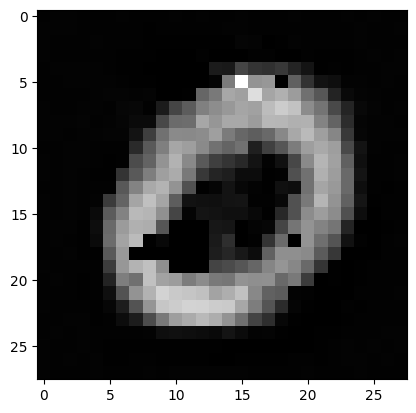

Discriminator real loss 0.20412521064281464
Discriminator fake loss 0.04009750485420227
Discriminator real loss 0.14281247556209564
Discriminator fake loss 0.045422568917274475
Generator loss 0.08918604999780655
Generator auxiliary loss 0.2364957481622696
Generator loss 0.09725973755121231
Generator auxiliary loss 0.23535709083080292
Generator loss 0.046483613550662994
Generator auxiliary loss 0.23579569160938263
0.022142918780446053


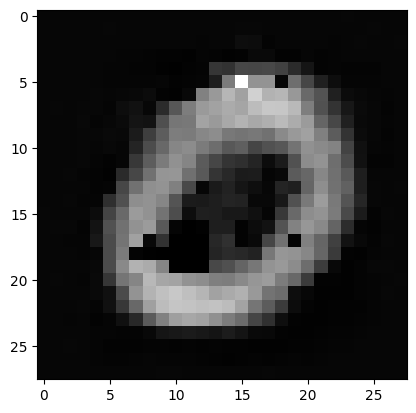

Discriminator real loss 0.14670854806900024
Discriminator fake loss 0.06654036045074463
Discriminator real loss 0.16208234429359436
Discriminator fake loss 0.07426097244024277
Generator loss 0.07811618596315384
Generator auxiliary loss 0.2386804074048996
Generator loss 0.05726468563079834
Generator auxiliary loss 0.23870089650154114
Generator loss 0.049601227045059204
Generator auxiliary loss 0.23874147236347198
0.03321705013513565


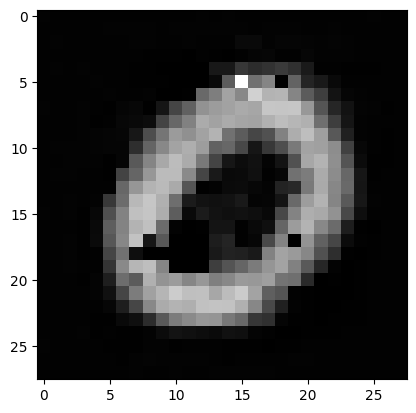

Discriminator real loss 0.11922191083431244
Discriminator fake loss 0.09607069939374924
Discriminator real loss 0.12326490134000778
Discriminator fake loss 0.05958443507552147
Generator loss 0.05777611956000328
Generator auxiliary loss 0.2336692363023758
Generator loss 0.052115947008132935
Generator auxiliary loss 0.23419933021068573
Generator loss 0.059027716517448425
Generator auxiliary loss 0.23380248248577118
0.03704299405217171


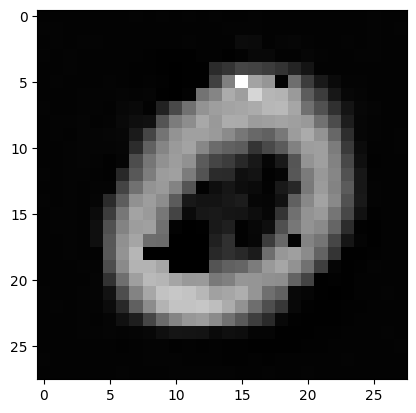

Discriminator real loss 0.20863167941570282
Discriminator fake loss 0.057514943182468414
Discriminator real loss 0.17608901858329773
Discriminator fake loss 0.09578804671764374
Generator loss 0.07090511918067932
Generator auxiliary loss 0.23410235345363617
Generator loss 0.071505606174469
Generator auxiliary loss 0.2340884804725647
Generator loss 0.062428493052721024
Generator auxiliary loss 0.23468443751335144
0.02884056605398655


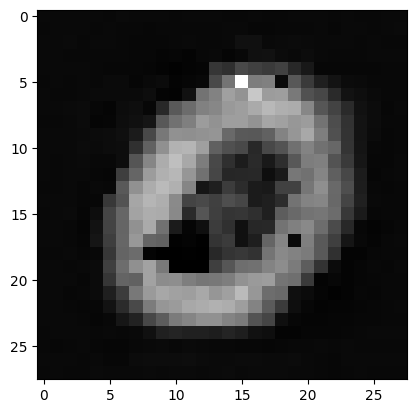

KeyboardInterrupt: ignored

In [80]:
#Train the model
for epoch in range(epochs):
    #Go through all the data in training set
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        for _ in range(num_train_discriminator):
            #Train the discriminator
            discriminator.zero_grad()

            #This is the real image
            output = discriminator(images)
            loss_discriminator_real = criterion_discriminator(output, labels)

            #This is the fake image
            input_tensor = input_creator(labels)
            images_generated = generator(input_tensor)
            output = discriminator(images_generated)
            label = torch.full_like(output, 11)
            loss_discriminator_fake = criterion_discriminator(output, labels)

            optimizer_discriminator.zero_grad()
            loss_discriminator = (loss_discriminator_real + loss_discriminator_fake)/2
            if(labels.numel() != batch_size):
                print("Discriminator real loss", loss_discriminator_real.item())
                print("Discriminator fake loss", loss_discriminator_fake.item())
            loss_discriminator.backward()
            optimizer_discriminator.step()

        for _ in range(num_train_generator):
            #Train the generator
            generator.zero_grad()

            input_tensor = input_creator(labels)
            images_generated = generator(input_tensor)
            output = discriminator(images_generated)
            loss_generator = criterion_discriminator(output, labels)
            loss_generator_auxiliary = criterion_generator(images_generated, images)

            optimizer_generator.zero_grad()
            generator_loss_sum = auxiliary_loss_ratio * loss_generator_auxiliary + loss_generator
            if(labels.numel() != batch_size):
                print("Generator loss", loss_generator.item())
                print("Generator auxiliary loss", loss_generator_auxiliary.item())
            generator_loss_sum.backward()
            optimizer_generator.step()

    #Step down learning rate
    # scheduler_generator.step()
    # scheduler_discriminator.step()

    #Generating an image
    labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
    input_tensor = input_creator(labels)
    images_generated = generator(input_tensor)

    #Keeping the power of discriminator and generator in check
    output = discriminator(images_generated)
    discriminato_loss = criterion_discriminator(output, labels)
    print(discriminato_loss.item())
    if(discriminato_loss.item()<0.1):
        num_train_discriminator = 2
        num_train_generator = 3
    elif(discriminato_loss.item()>0.4):
        num_train_discriminator = 3
        num_train_generator = 2
    else:
        num_train_discriminator = 2
        num_train_generator = 2

    # #Visualization
    # print(output.mean())
    images_generated = images_generated.to("cpu").detach()
    for i in range(1):
        plt.imshow(images_generated[i][0], cmap='gray')
        plt.show()

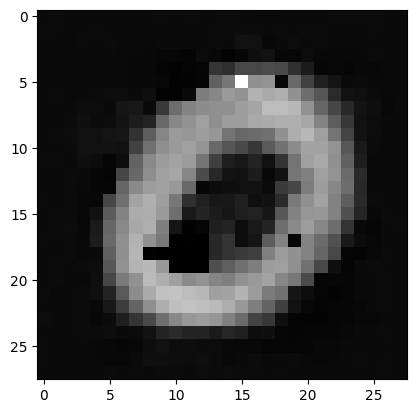

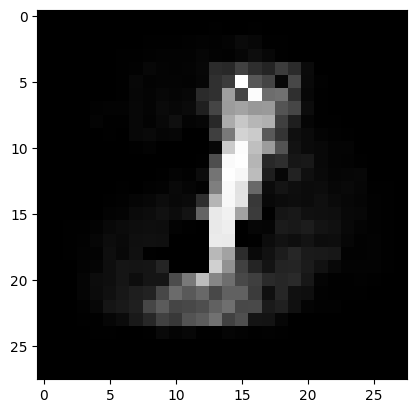

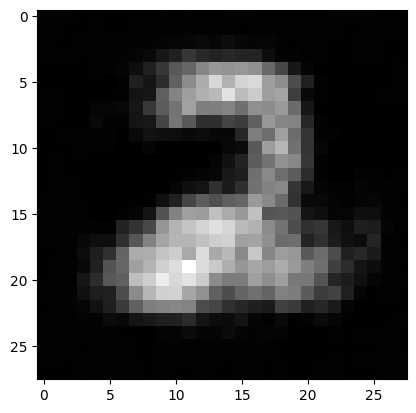

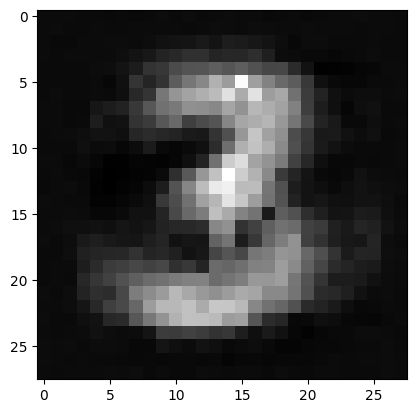

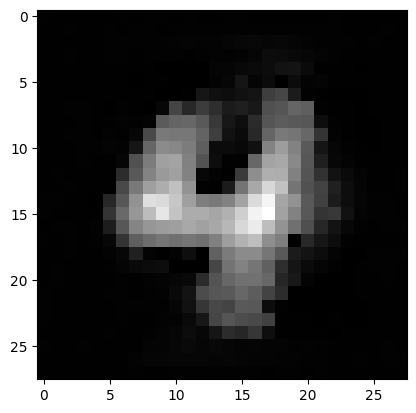

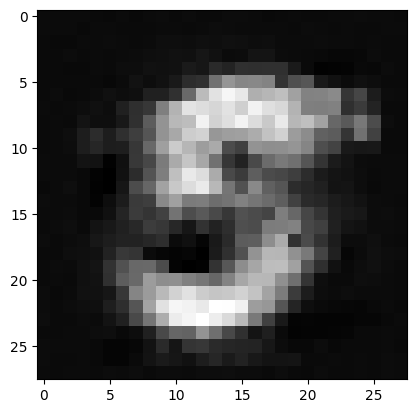

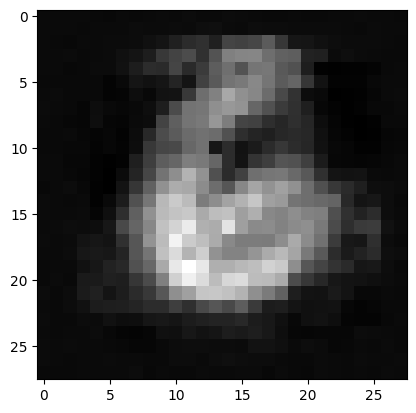

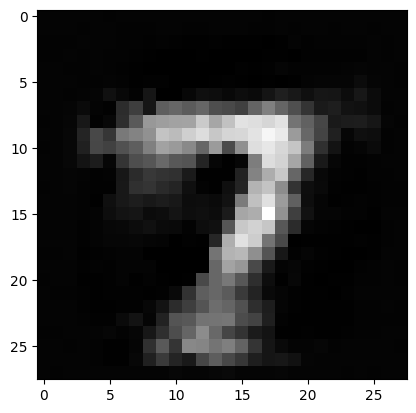

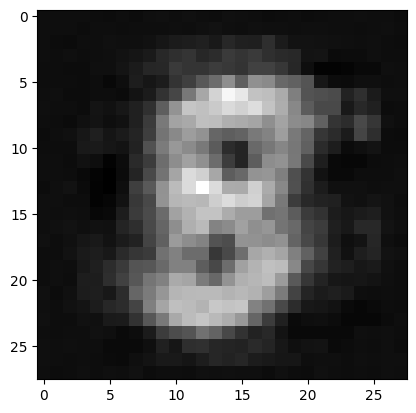

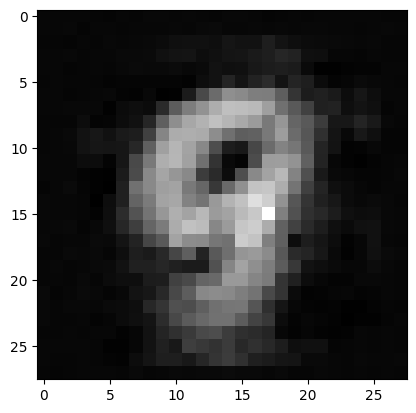

In [81]:
#Generate numbers from 0 to 9
labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
input_tensor = input_creator(labels)
images_generated = generator(input_tensor)
images_generated = images_generated.to("cpu").detach()
for i in range(10):
    plt.imshow(images_generated[i][0], cmap='gray')
    plt.show()

In [83]:
torch.save(generator, "gen.plt")
torch.save(discriminator, "disc.plt")